### О ЛР:

- подкапотное представление SVM и логистической регресии
- Калибровка вероятностей, калибровочные кривые
- Feature Enginnering (отбор признаков, счетчики)
- Экономический эффект модели от внедрения в боевой режим

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**:

***DeadLine - 24.04.2024 23:59***



## Инструкция по сдаче ДЗ.



0. Просмотр лекции обязателен. Не потому что без этого невозможно выполнить домашнее задание, а потому что с этим выполнение домашнего задания станет комфортным, приятным и быстрым. Вы потратите намного меньше времени для изучения материала и понимания того, что от Вас хотят, нежели сразу приступите к выполнению домашнего задания без просмотра лекции.

1. Скопируйте к себе колаб-ноутбук.

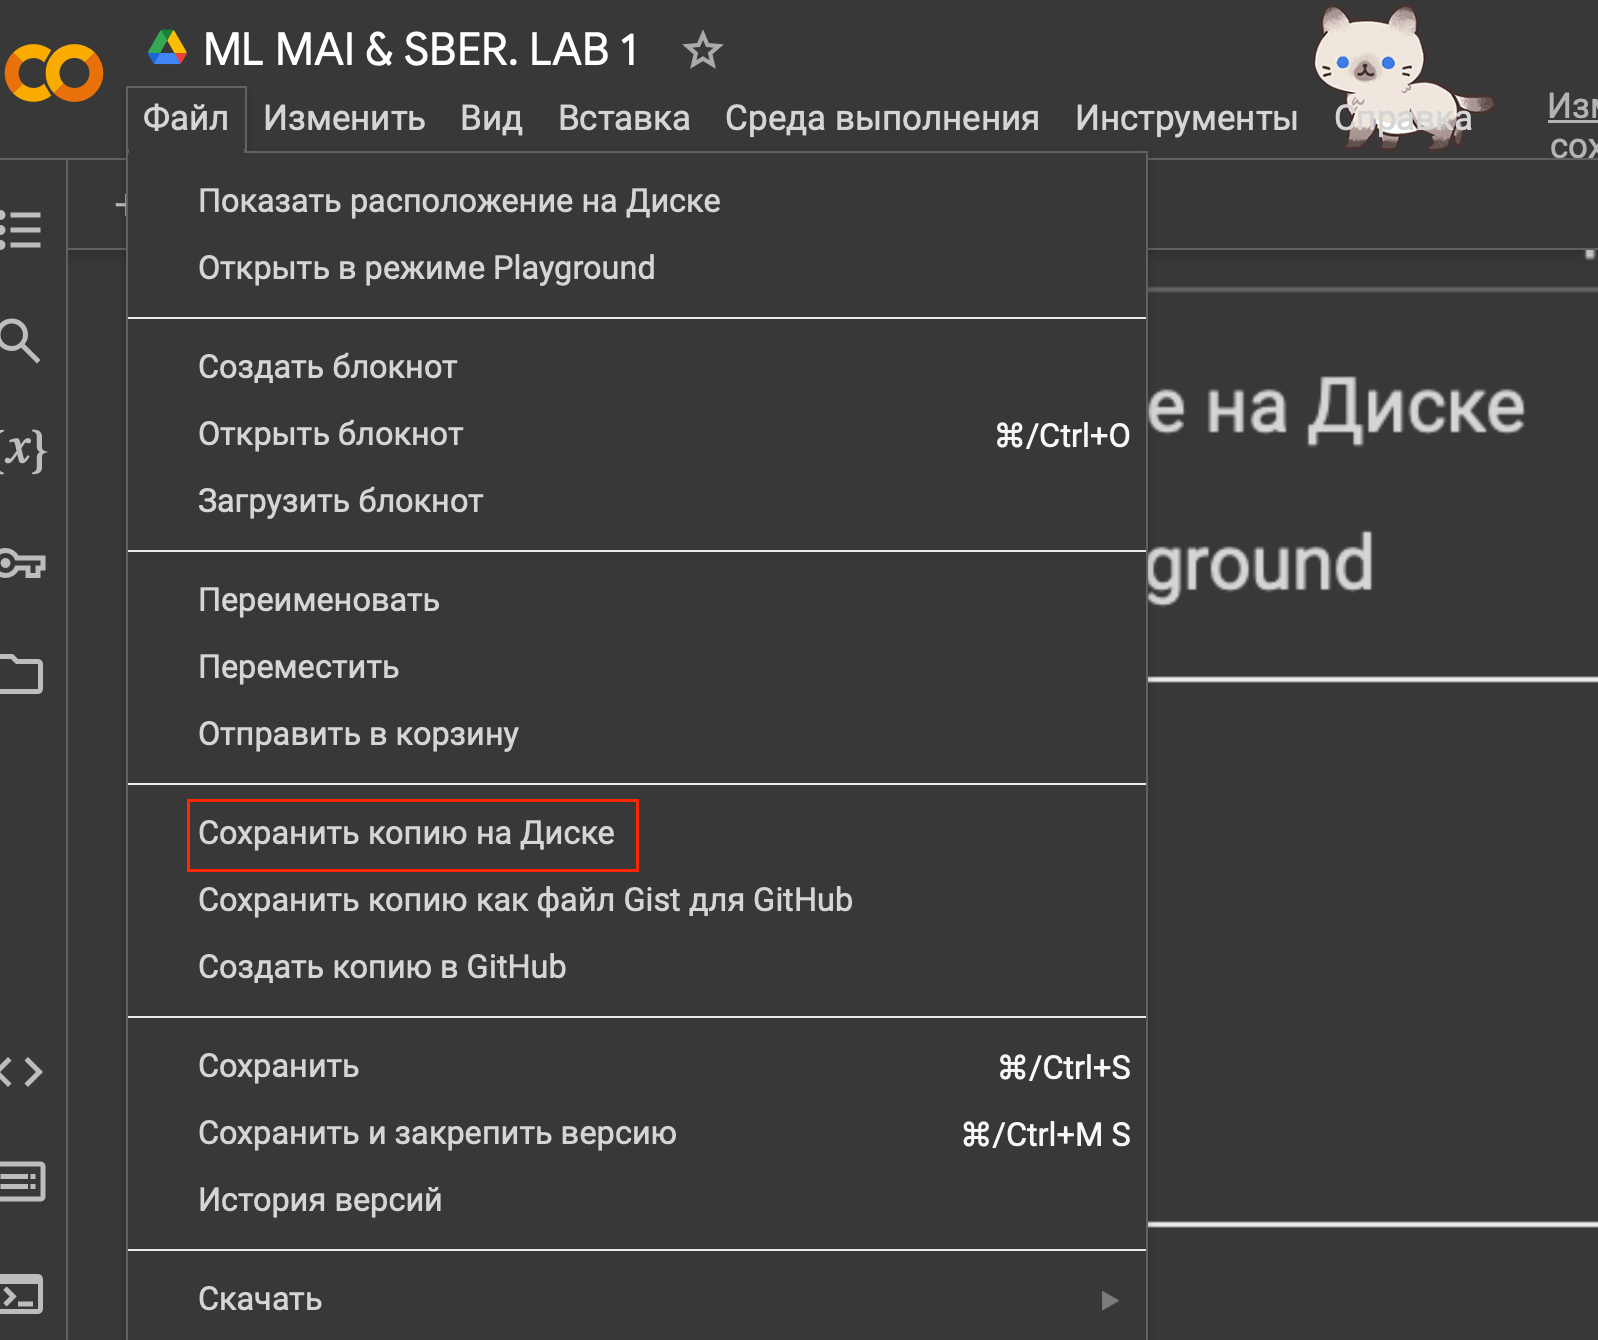

2. у Вас откроется файл в новой вкладке с названием "Копия...". После описания задания вы пишите решение этого задания.

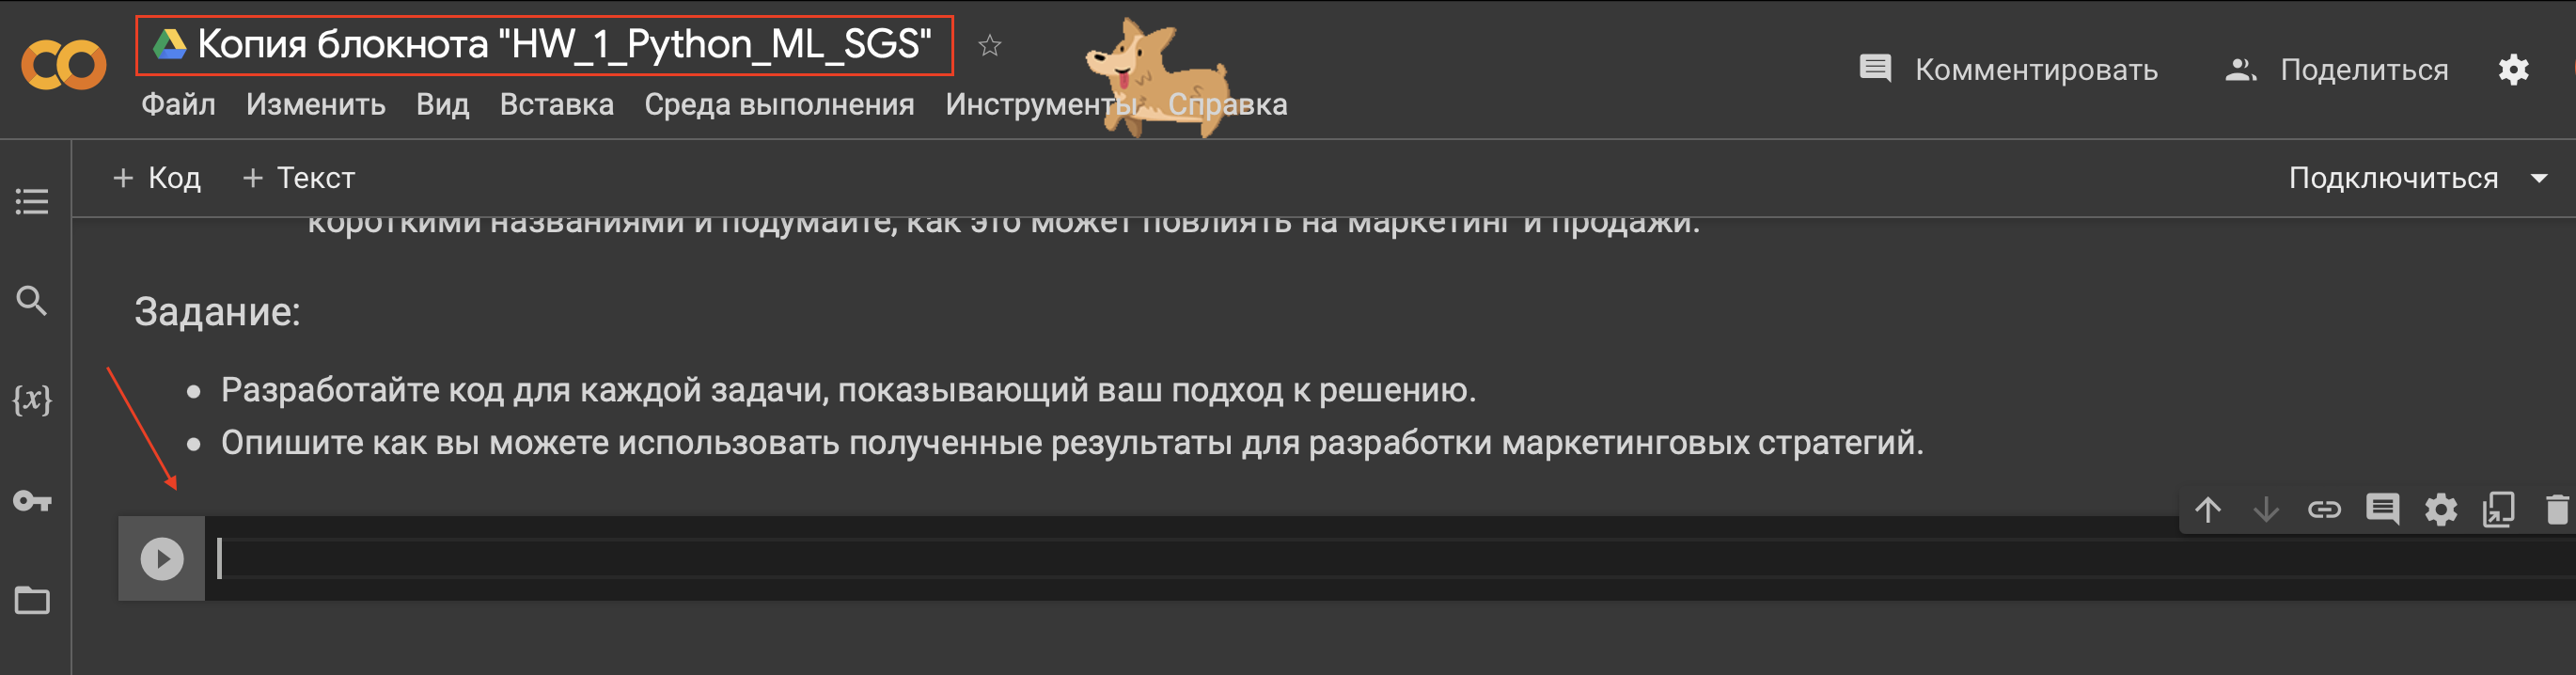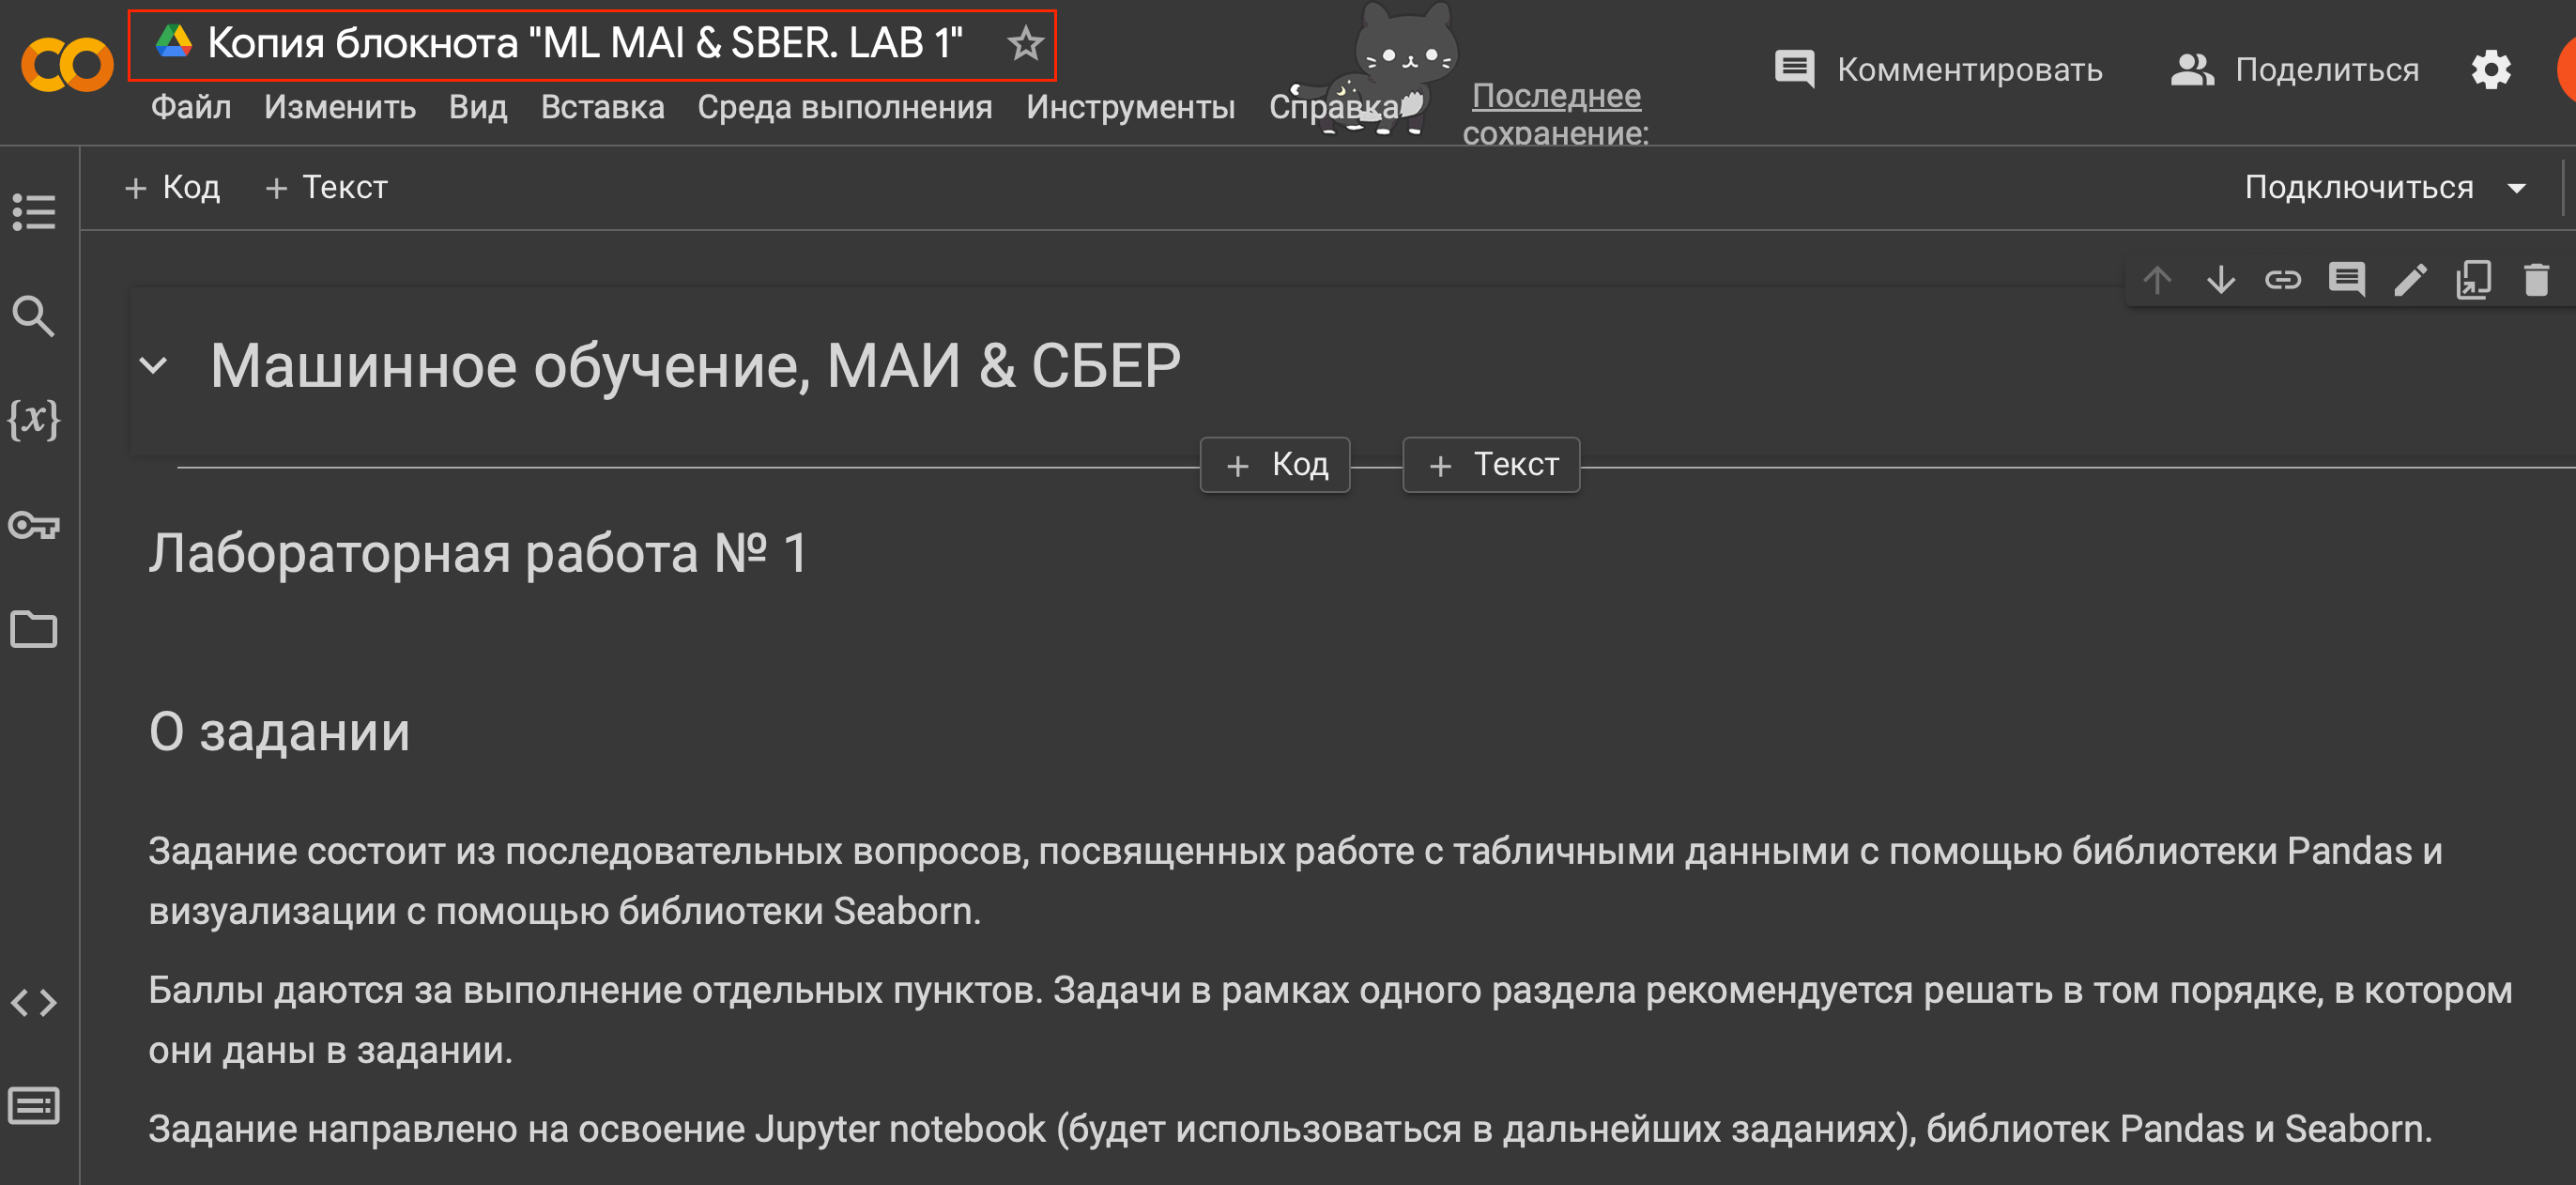

3. После выполнения домашнего задания нажмите кнопку "поделиться" и перейдите в режим доступно всем по ссылке

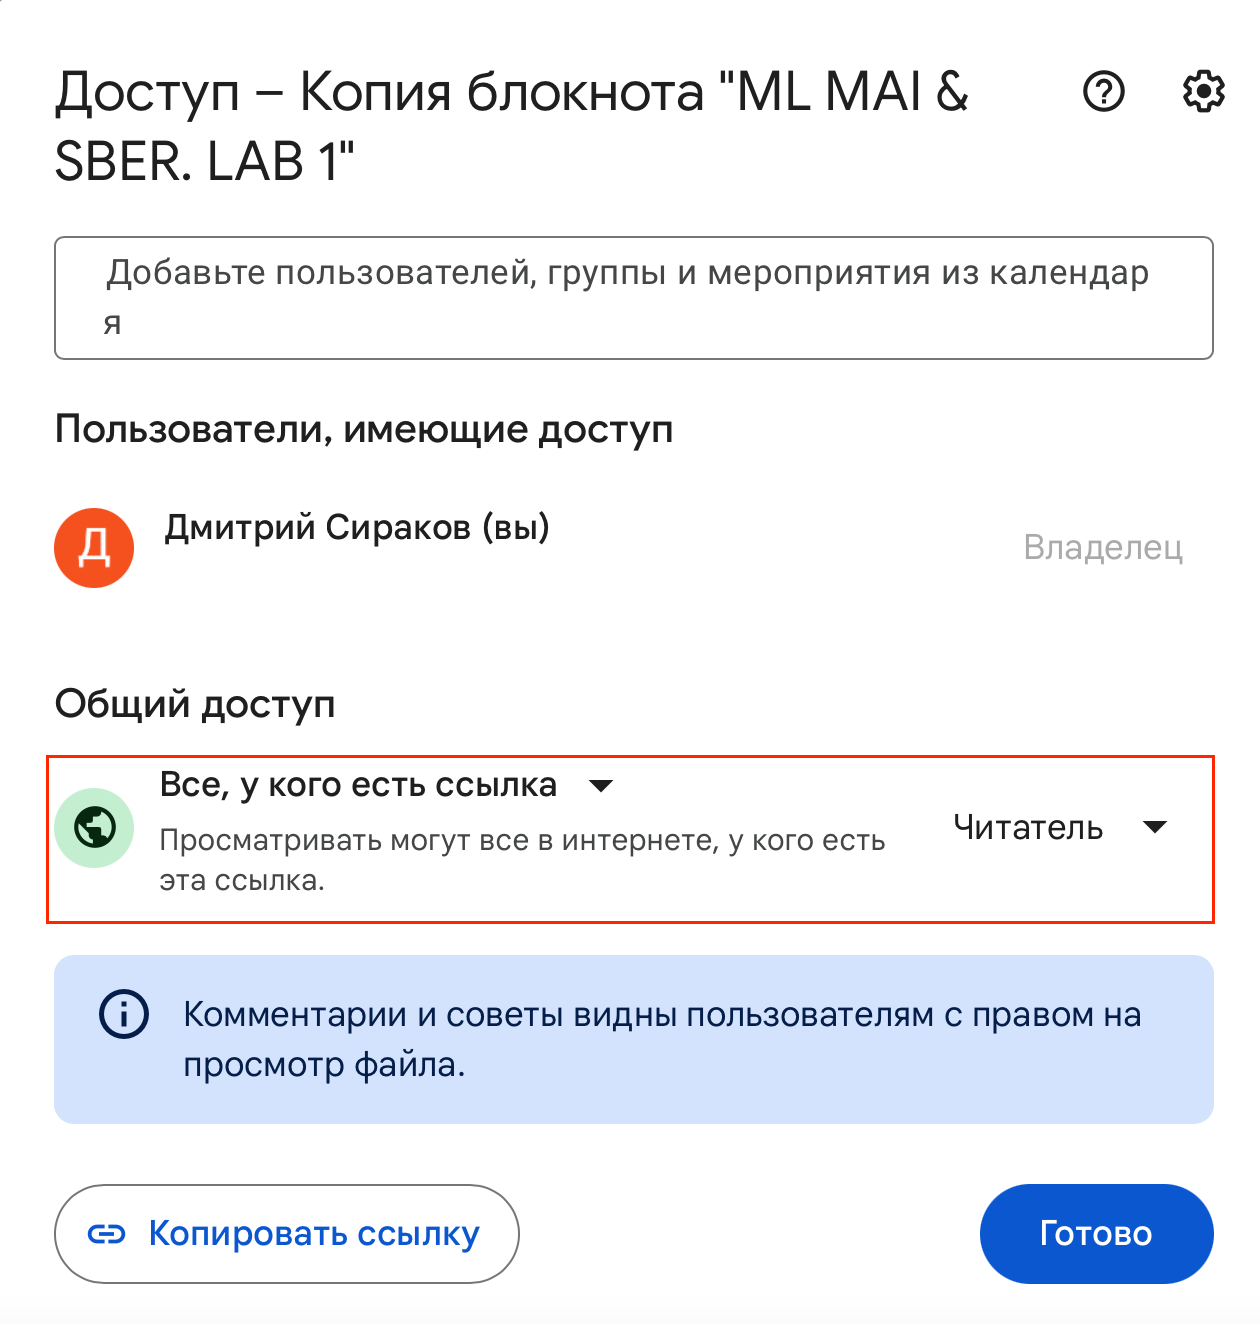

4. Загрузите эту ссылку в lms.mai.ru по курсу "Машинное обучение" в качестве ссылки в раздел "Линейная классификация с Scikit-learn и Seaborn для визуализации (ЛР)[06.04]"


## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 5 баллов.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты не могут получить за него больше 0 баллов.

Неэффективная реализация кода может негативно отразиться на оценке.

# Часть 1. SVM, LR и калибровка вероятностей (1.25 балла)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### __Задание 1.1  Сравнение методов__ (0.25 балла)



Сгенерируем синтетические данные.

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [3]:
np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True)

((array([0, 1]), array([3522, 3478])), (array([0, 1]), array([1483, 1517])))

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

**AUC-ROC**:
- ROC-кривая (Receiver Operating Characteristic curve) - это график, который показывает производительность классификационной модели при всех пороговых значениях классификации. Она изображает две величины: True Positive Rate (TPR, чувствительность) и False Positive Rate (FPR, 1-специфичность).
- AUC (Area Under the Curve) - это площадь под ROC-кривой. Значение AUC лежит в диапазоне от 0 до 1. Модель с AUC, равным 1, является идеальным классификатором, а модель с AUC, равным 0.5, не имеет классификационной способности.

**AUC-PR**:
- PR-кривая (Precision-Recall curve) - это график, который показывает зависимость точности (precision) от полноты (recall) для различных пороговых значений.
- AUC-PR также является площадью под PR-кривой. Эта метрика особенно полезна в случаях, когда классы сильно несбалансированы. Максимальное значение AUC-PR равно 1, что означает идеальную классификацию, а минимальное значение зависит от соотношения классов в данных.

In [4]:
from sklearn.dummy import DummyClassifier

random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:, 1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: ╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

Предсказание выполнялось по равномерному вероятностному распределению `strategy='uniform'`, вероятность принадлежности к любому из классов будет равна 0.5. 

Иными словами, модель считает, что каждый объект имеет 50% вероятность принадлежности к классу 1 и 50% вероятность принадлежности к классу 0. 

То есть y_random представляют собой вероятности, а не предсказанные классы.



In [5]:
y_random_binary = random_classifier.predict(X_test)
y_random_binary


array([0, 1, 0, ..., 0, 1, 1])

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [6]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import RocCurveDisplay

Random Classifier AUC-PR: 0.75283
Random Classifier AUC-ROC: 0.50000


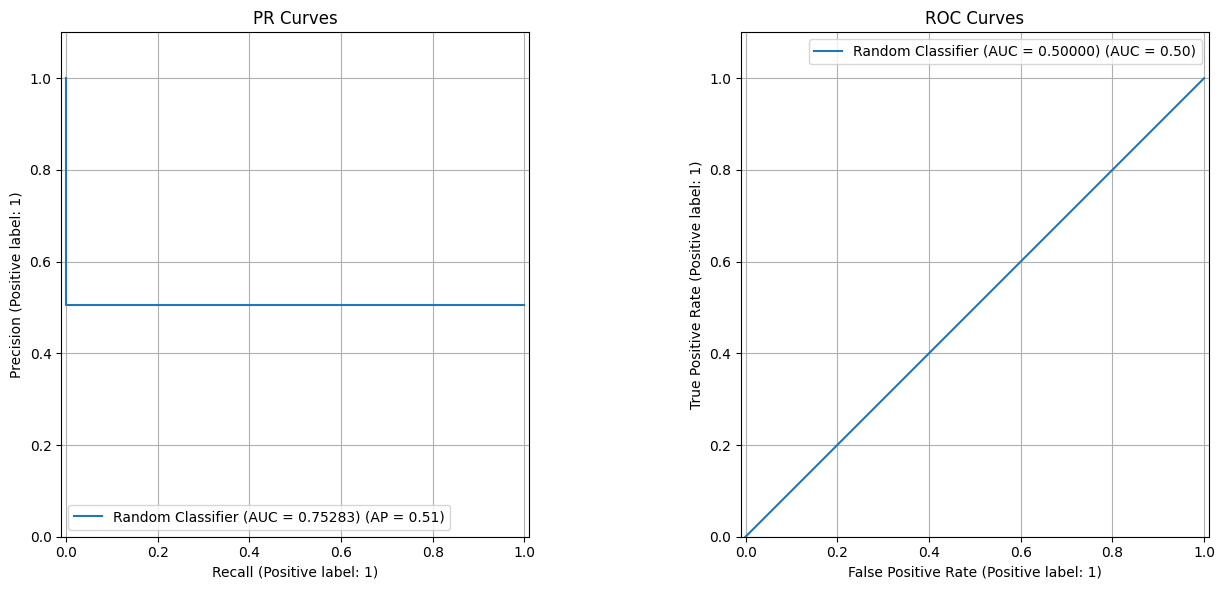

In [7]:
def depict_pr_roc(y_true, y_preds, classifier_names, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    for y_pred, name in zip(y_preds, classifier_names):
        # Вычисление метрик для PR-кривой
        precision, recall, _ = precision_recall_curve(y_true, y_pred)
        auc_pr = auc(recall, precision)
        print(f'{name} AUC-PR: {auc_pr:.5f}')
        PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=f'{name} (AUC = {auc_pr:.5f})')

        # Вычисление метрик для ROC-кривой
        # fpr, tpr, _ = roc_curve(y_true, y_pred)
        auc_roc = roc_auc_score(y_true, y_pred)
        print(f'{name} AUC-ROC: {auc_roc:.5f}')
        RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=f'{name} (AUC = {auc_roc:.5f})')

    # Настройки для PR-кривой
    ax[0].set_title("PR Curves")
    ax[0].set_ylim(0, 1.1)
    ax[0].grid(True)

    # Настройки для ROC-кривой
    ax[1].set_title("ROC Curves")
    ax[1].set_ylim(0, 1.1)
    ax[1].grid(True)

    plt.tight_layout()
    plt.legend()
    plt.show()


depict_pr_roc(y_test, [y_random], ['Random Classifier'])

In [8]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])
precision, recall, _ = precision_recall_curve(y_test, y_random)
# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
    auc(recall, precision),
    roc_auc_score(y_test, y_random),
    0
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`).

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


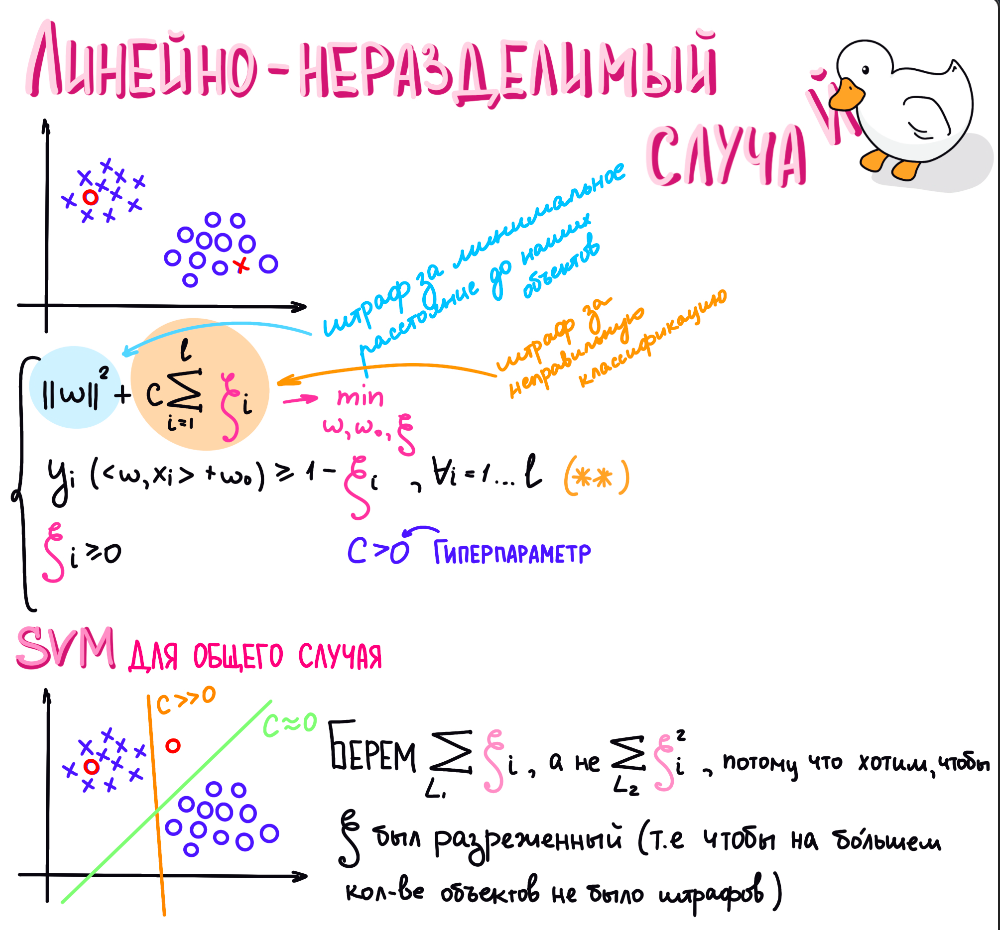

In [9]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10]}

svm = SVC(kernel='linear', probability=True, random_state=42)

grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='average_precision', verbose=1)
grid_search.fit(X_train, y_train)

best_svm = grid_search.best_estimator_

y_svm = best_svm.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_svm)
df_metrics.loc['SVM (Linear Kernel)'] = [
    auc(recall, precision),
    roc_auc_score(y_test, y_svm),
    grid_search.best_params_['C']
]

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [10]:
#╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

Random Classifier AUC-PR: 0.75283
Random Classifier AUC-ROC: 0.50000
SVM (Linear Kernel) AUC-PR: 0.81484
SVM (Linear Kernel) AUC-ROC: 0.84788


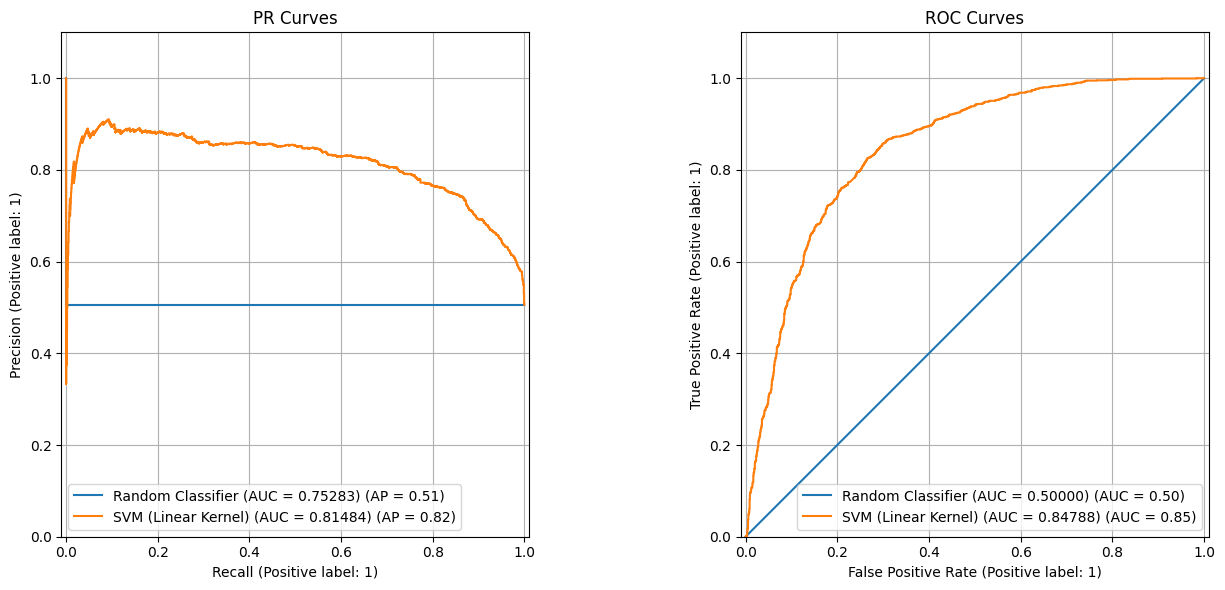

In [11]:
y_preds = [y_random, y_svm]
classifier_names = ['Random Classifier', 'SVM (Linear Kernel)']

depict_pr_roc(y_test, y_preds, classifier_names)

In [12]:
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.50000,0.0
SVM (Linear Kernel),0.814837,0.84788,10.0


In [13]:
#╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

### Выводы

1. Значение AUC-ROC для случайного классификатора равно 0.5, что ожидаемо, поскольку случайный классификатор не обладает предсказательной способностью и его работа эквивалентна случайному угадыванию по равномерному распределению. Значение AUC-ROC для SVM составляет 0.84788, что значительно выше и указывает на хорошую предсказательную способность модели.




2. AUC-PR для случайного классификатора довольно высоко (0.75283). Это значение несколько выше ожидаемого для случайного классификатора. Это связано с тем, что данные сбалансированы, и модель может иметь случайные попадания в верные классы, что приводит к несколько завышенному значению AUC-PR. Тем не менее, SVM показывает еще более высокое значение AUC-PR (0.81484), что указывает на лучшее качество модели.



### Заключение

Модель SVM с линейным ядром существенно превосходит случайный классификатор по обеим метрикам (AUC-ROC и AUC-PR), что подтверждает её эффективность и способность более точно классифицировать данные.

In [14]:
#╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

__Logistic Regression__





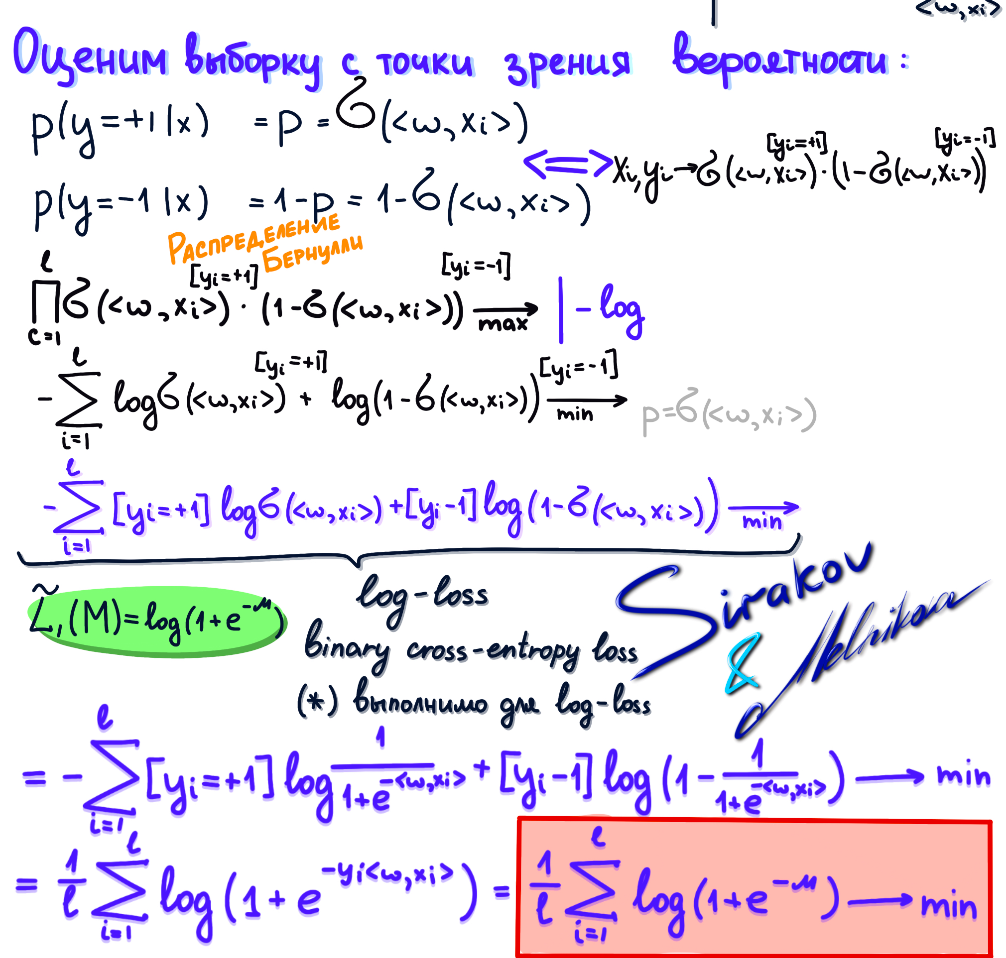

Давай проведем анализ эффективности логистической регрессии с регуляризацией L2 для бинарной классификации.

Вот наши шаги:

1. **Определение гиперпараметра C**: Начнем с подбора гиперпараметра C, который контролирует силу регуляризации в логистической регрессии. Для этого используем метрику AUC-PR, которая показывает баланс между точностью и полнотой. Выбор оптимального значения C поможет нам улучшить производительность модели, особенно в условиях несбалансированных данных.

2. **Визуализация кривых ROC и PR**: После того как мы определим наилучший гиперпараметр C, нарисуем ROC и PR кривые для тестовых данных. Эти кривые помогут нам оценить, насколько хорошо наша модель различает классы и как она справляется с балансом между точностью и полнотой.

3. **Оценка метрик**: Наконец, выведем ключевые метрики для тестовых данных, такие как AUC-ROC и AUC-PR, чтобы оценить производительность логистической регрессии. Сравним эти результаты с показателями случайного классификатора, чтобы понять, насколько наша модель превосходит случайное угадывание.


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

log_reg = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)

grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='average_precision', verbose=1)
grid_search.fit(X_train, y_train)

best_log_reg = grid_search.best_estimator_

y_log_reg = best_log_reg.predict_proba(X_test)[:, 1]

print("Best hyperparameter C:", grid_search.best_params_['C'])


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best hyperparameter C: 100


In [16]:
#╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

Random Classifier AUC-PR: 0.75283
Random Classifier AUC-ROC: 0.50000
SVM (Linear Kernel) AUC-PR: 0.81484
SVM (Linear Kernel) AUC-ROC: 0.84788
Logistic Regression (L2) AUC-PR: 0.82912
Logistic Regression (L2) AUC-ROC: 0.84788


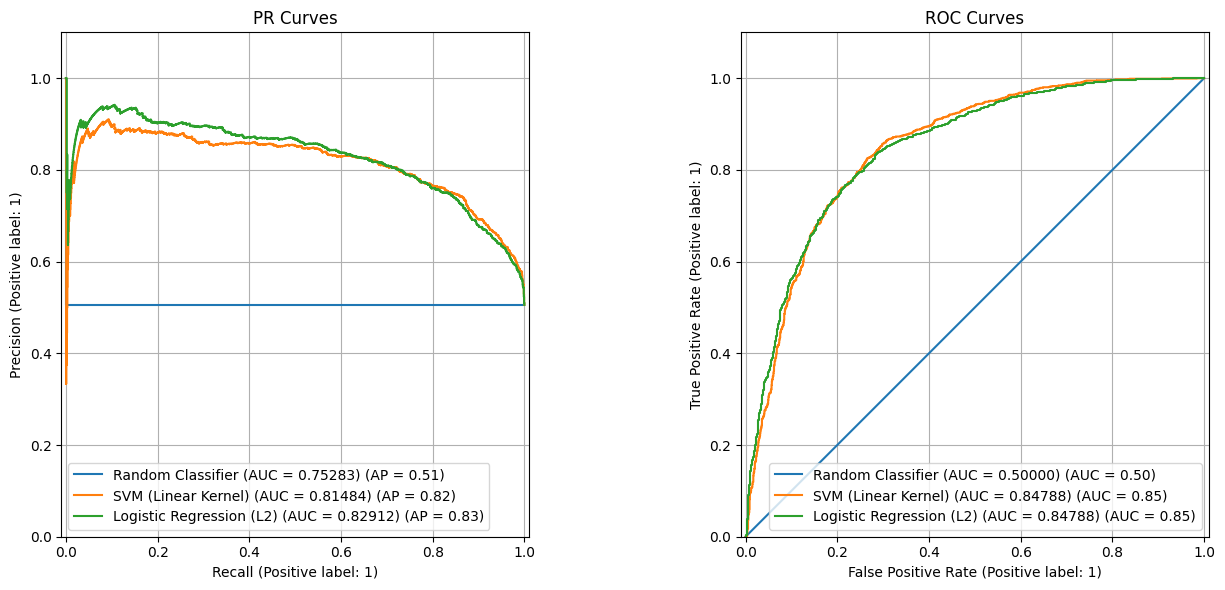

In [17]:
y_preds = [y_random, y_svm, y_log_reg]
classifier_names = ['Random Classifier', 'SVM (Linear Kernel)', 'Logistic Regression (L2)']

depict_pr_roc(y_test, y_preds, classifier_names)

In [18]:

precision, recall, _ = precision_recall_curve(y_test, y_log_reg)
df_metrics.loc['Logistic Regression (L2)'] = [
    auc(recall, precision),
    roc_auc_score(y_test, y_log_reg),
    grid_search.best_params_['C']
]


In [19]:
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.500000,0.0
SVM (Linear Kernel),0.814837,0.847880,10.0
Logistic Regression (L2),0.829121,0.847879,100.0


In [ ]:
#╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

Логистическая регрессия (L2):

AUC-ROC: 0.847879 — Очень близкое значение к SVM, что также указывает на хорошую предсказательную способность модели.
AUC-PR: 0.829121 — Немного выше, чем у SVM, что может указывать на то, что логистическая регрессия лучше справляется с задачей классификации в условиях сбалансированных данных.


**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** ╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

- Логистическая регрессия (L2) показывает немного лучшее значение AUC-PR, что делает её предпочтительной в задачах, где важно учитывать точность и полноту.

- SVM (Linear Kernel) и логистическая регрессия имеют практически идентичные значения AUC-ROC, что указывает на схожую производительность в общем случае.

AUC-PR: Логистическая регрессия немного лучше справляется с балансом между точностью и полнотой, что важно в контексте задач, где положительные классы редки и необходимо максимизировать точность (precision) при сохранении высокого уровня полноты (recall).

Значение параметра регуляризации C у логистической регрессии выше, что может быть связано с особенностями модели. Логистическая регрессия, возможно, требует более сильной регуляризации для предотвращения переобучения на данных по сравнению с SVM.

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.25 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`).

Я изначально `SVC(kernel='linear')` использовал

In [20]:
#╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

from sklearn.datasets import make_classification
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt

# Генерация синтетических данных
X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, random_state=42)

# Обучение метода опорных векторов с линейным ядром
model = SVC(kernel='linear', random_state=42)
model.fit(X, y)


SVC(kernel='linear', random_state=42)

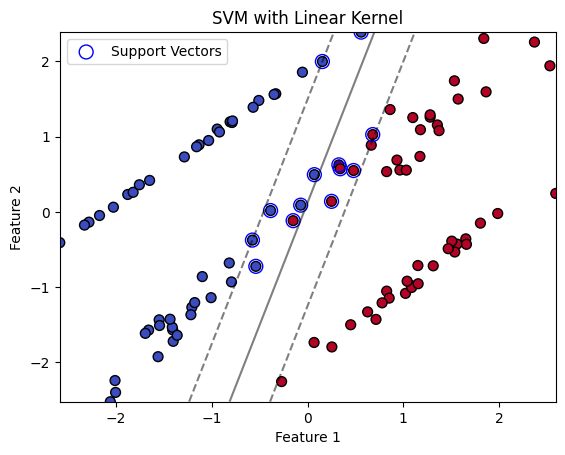

In [21]:
def plot_svm_2D(X, y, model, plot_support=True):
    # Создание сетки
    xx = np.linspace(X[:, 0].min(), X[:, 0].max(), 30)
    yy = np.linspace(X[:, 1].min(), X[:, 1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Предсказания модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(XX.shape)

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    # Отрисовка выборки
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=50, edgecolors='k')

    # Отрисовка опорных векторов
    if plot_support:
        plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1],
                    s=100, linewidth=1, edgecolor="blue", facecolors='none', label='Support Vectors')

    plt.legend()
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("SVM with Linear Kernel")
    plt.show()


plot_svm_2D(X, y, model)


**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** 

**Опорные векторы** — это точки из обучающей выборки, которые находятся на границе разделения между классами. Эти объекты:

- Находятся на линиях поддержки (линиях уровня), расположенных на расстоянии +1 и -1 от разделяющей гиперплоскости.
- Оказывают непосредственное влияние на положение разделяющей гиперплоскости.

На графике синие опорные векторы выделены кругами без заливки. Эти точки находятся рядом с линиями уровня и являются ключевыми для построения модели SVM.

Давайте покажем, как логистическая регрессия отражает вероятности принадлежности к классам в данных. Вместо того чтобы стремиться создать промежуток с отступом, как это делает метод опорных векторов, логистическая регрессия моделирует вероятность того, что объект принадлежит к положительному классу в каждой точке пространства признаков.

Мы собираемся визуализировать, как выглядит пространство вероятностей, которое логистическая регрессия "видит" при прогнозировании классов. На нашем графике каждая точка будет показывать шанс того, что объект относится к положительному классу

In [24]:
# Генерация синтетических данных с 2 признаками
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, random_state=42)

# Обучение логистической регрессии
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X, y)

LogisticRegression(random_state=42)

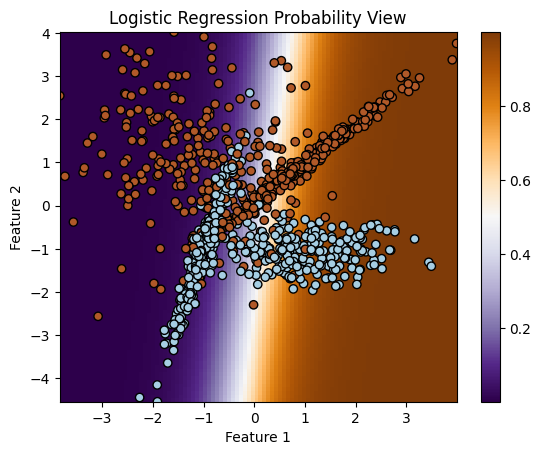

In [25]:
def plot_logreg_2D(X, y, model):
    # Создание сетки
    xx = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
    yy = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(xy)[:, 1]
    Z = Z.reshape(XX.shape)

    # Отображение вероятностей
    image = plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)

    # Отрисовка выборки
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
    plt.colorbar(image)
    plt.title("Logistic Regression Probability View")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()


plot_logreg_2D(X, y, log_reg)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?

**Ответ:** 

На графике область, где модель логистической регрессии не уверена в классификации (т.е., где вероятность принадлежности к положительному классу ($p(y=+1|x))$ равна 0.5), представлена в виде полосы, проходящей через центр изображения. Эта область отображена в тёмном цвете, который находится между фиолетовым (низкая вероятность принадлежности к положительному классу) и оранжевым (высокая вероятность принадлежности к положительному классу).

### Теоретическое обоснование

1. **Логистическая регрессия**:
   - Модель логистической регрессии предсказывает вероятность принадлежности объекта к положительному классу с помощью логистической функции (сигмоиды):
     
     $p(y=1|x) = \sigma(w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$
     
   - Здесь \( w \) — это вектор весов модели, \( x \) — вектор признаков, а \( b \) — смещение (bias).

2. **Граница принятия решения**:
   - Граница принятия решения в логистической регрессии проходит там, где вероятность принадлежности к положительному классу равна 0.5:

     $\frac{1}{1 + e^{-(w^T x + b)}} = 0.5$
    
   - Это равенство достигается, когда аргумент экспоненты равен нулю:
     
     $w^T x + b = 0$
     
   - Таким образом, граница принятия решения является линейной, и она проходит через пространство признаков, разделяя его на две области с разными вероятностями принадлежности к классам.

3. **Интерпретация на графике**:
   - На графике белая полоса представляет собой область, где $ w^T x + b \approx 0 $, что соответствует $ p(y=+1|x) \approx 0.5 $.
   - Чем дальше точка от этой границы, тем более уверена модель в своей классификации:
     - фиолетовые области (низкие значения $ w^T x + b $) указывают на высокую уверенность в отрицательном классе ($ p(y=+1|x) $ близка к 0).
     - оранжевые области (высокие значения $ w^T x + b $) указывают на высокую уверенность в положительном классе ($ p(y=+1|x) $ близка к 1).

Таким образом, белая полоса на графике логистической регрессии показывает область, где модель не уверена в классификации, так как вероятность принадлежности к положительному классу равна 0.5.


#### __Задание 2. Калибровка вероятностей__ (0.5 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной кривой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

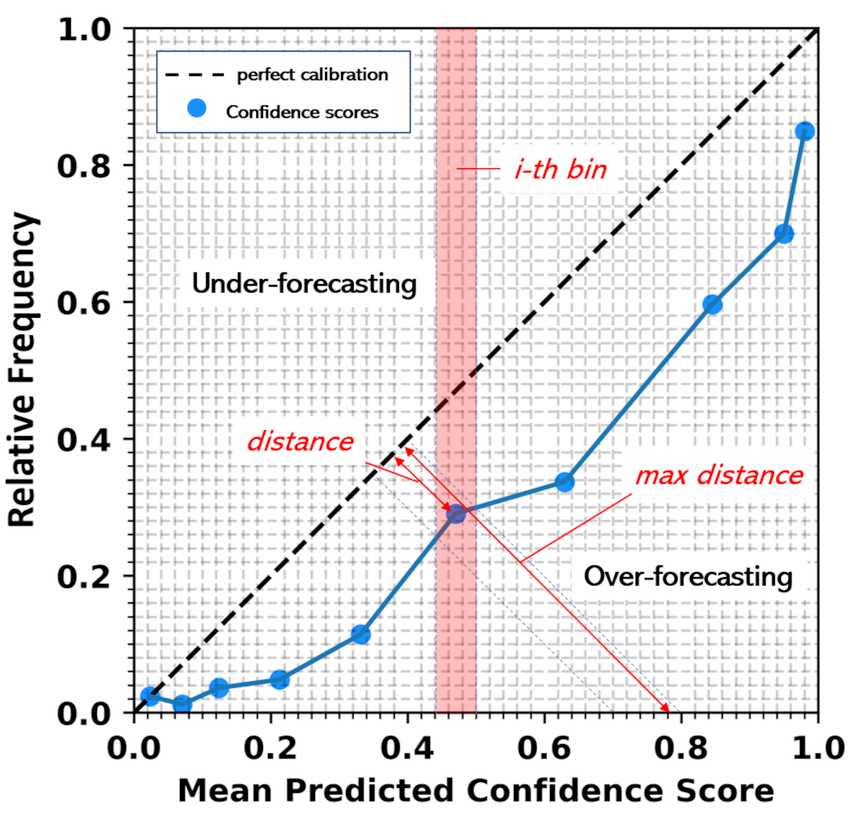

**Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.**

In [29]:
def plot_calibration_curve(y_test, preds, model_name):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)  # Исправлено на среднее значение
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))  # Используем среднее значение

    plt.plot(bin_middle_points, bin_real_ratios, marker='o', linestyle='-', label=f'{model_name} (Calibration)')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray',
             label='Perfect Calibration')  # Добавляем диагональ для идеальной калибровки
    plt.xlabel('Mean Predicted Confidence Score')
    plt.ylabel('Relative Frequency')
    plt.ylim([-0.05, 1.05])
    plt.grid()
    plt.title('Calibration Curve')

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [26]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

svm = SVC(kernel='linear', probability=True, random_state=42)
svm.fit(X_train, y_train)

# Предсказание вероятностей
y_pred_log_reg = log_reg.predict_proba(X_test)[:, 1]
y_pred_svm = svm.predict_proba(X_test)[:, 1]


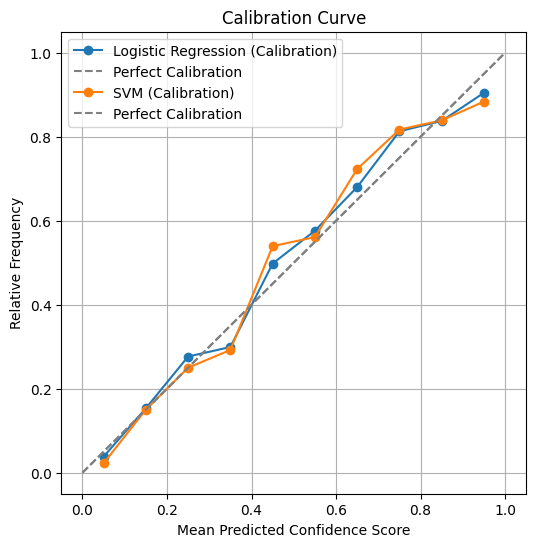

In [31]:
plt.figure(figsize=(6, 6))
plot_calibration_curve(y_test, y_pred_log_reg, 'Logistic Regression')
plot_calibration_curve(y_test, y_pred_svm, 'SVM')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии?

**Ответ:** ╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

**Обе модели (логистическая регрессия и SVM) хорошо откалиброваны:**

- **Логистическая регрессия**: Калибровочная кривая проходит близко к диагонали, указывая на отличную калибровку.
- **SVM**: Калибровочная кривая также близка к диагонали, показывая хорошую калибровку, хотя с небольшими отклонениями в некоторых областях.

В целом, предсказанные вероятности для обеих моделей адекватно отражают фактические вероятности положительного класса.


Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

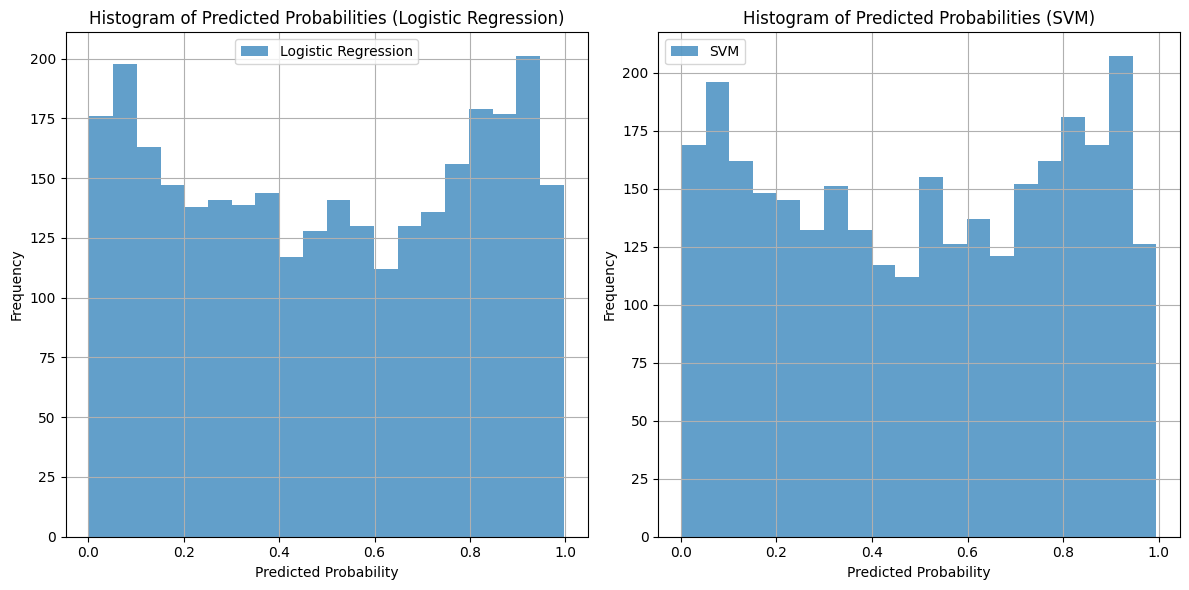

In [34]:
def plot_histograms(preds, model_name):
    plt.hist(preds, bins=20, alpha=0.7, label=model_name)
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Predicted Probabilities ({model_name})')
    plt.legend()


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plot_histograms(y_pred_log_reg, 'Logistic Regression')
plt.grid(True)

plt.subplot(1, 2, 2)
plot_histograms(y_pred_svm, 'SVM')

plt.tight_layout()
plt.grid(True)
plt.show()


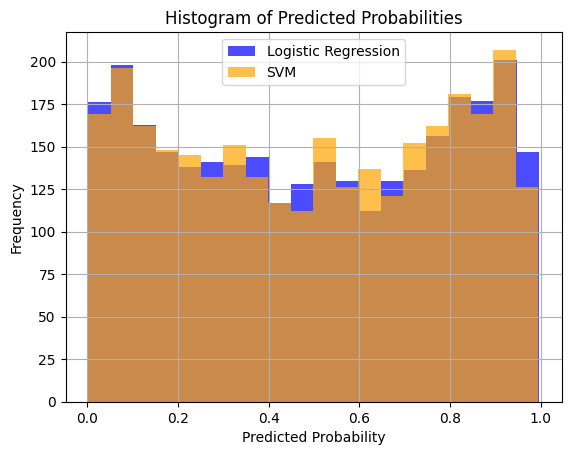

In [55]:
plt.hist(y_pred_log_reg, bins=20, alpha=0.7, label='Logistic Regression', color='blue')
plt.hist(y_pred_svm, bins=20, alpha=0.7, label='SVM', color='orange')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities')
plt.grid(True)
plt.legend()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** ╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

**Логистическая регрессия:**
- **Распределение вероятностей:** Равномерное распределение по всему диапазону [0, 1] с пиками около 0 и 1.
- **Интерпретация:** Логистическая регрессия напрямую моделирует вероятности, что приводит к более плавному распределению.

**Метод опорных векторов (SVM):**
- **Распределение вероятностей:** Менее равномерное распределение с пиками вблизи 0 и 1, более разреженное.
- **Интерпретация:** SVM преобразует расстояния до гиперплоскости в вероятности, что может создавать резкие изменения в распределении.

### Объяснение различий

1. **Моделирование вероятностей:**
   - **Логистическая регрессия:** Использует сигмоидную функцию, обеспечивая плавное распределение вероятностей.
   - **SVM:** Использует метод Платта для преобразования выходов модели в вероятности, что приводит к менее равномерному распределению.

2. **Алгоритм обучения:**
   - **Логистическая регрессия:** Минимизирует логистическую функцию потерь, что обеспечивает гладкость распределения.
   - **SVM:** Фокусируется на максимальном отступе, что может привести к резким изменениям в вероятностях.

### Заключение

- **Логистическая регрессия:** Более плавное и равномерное распределение предсказанных вероятностей.
- **SVM:** Менее равномерное, с резкими изменениями из-за метода преобразования вероятностей.

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

In [46]:
from sklearn.calibration import CalibratedClassifierCV

# Обучение метода опорных векторов с калибровкой
svm = SVC(kernel='linear', probability=True, random_state=42)
calibrated_svm = CalibratedClassifierCV(estimator=svm, method='sigmoid', cv=20)
calibrated_svm.fit(X_train, y_train)


CalibratedClassifierCV(cv=20,
                       estimator=SVC(kernel='linear', probability=True,
                                     random_state=42))

In [47]:

y_pred_calibrated_svm = calibrated_svm.predict_proba(X_test)[:, 1]


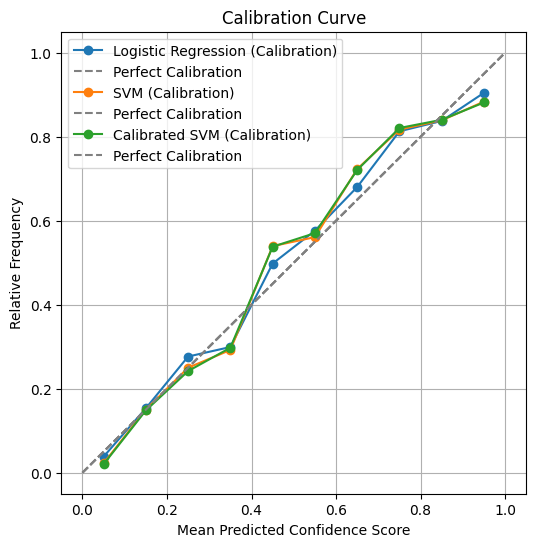

In [48]:
plt.figure(figsize=(6, 6))

plot_calibration_curve(y_test, y_pred_log_reg, 'Logistic Regression')
plot_calibration_curve(y_test, y_pred_svm, 'SVM')
plot_calibration_curve(y_test, y_pred_calibrated_svm, 'Calibrated SVM')

plt.legend()
plt.show()

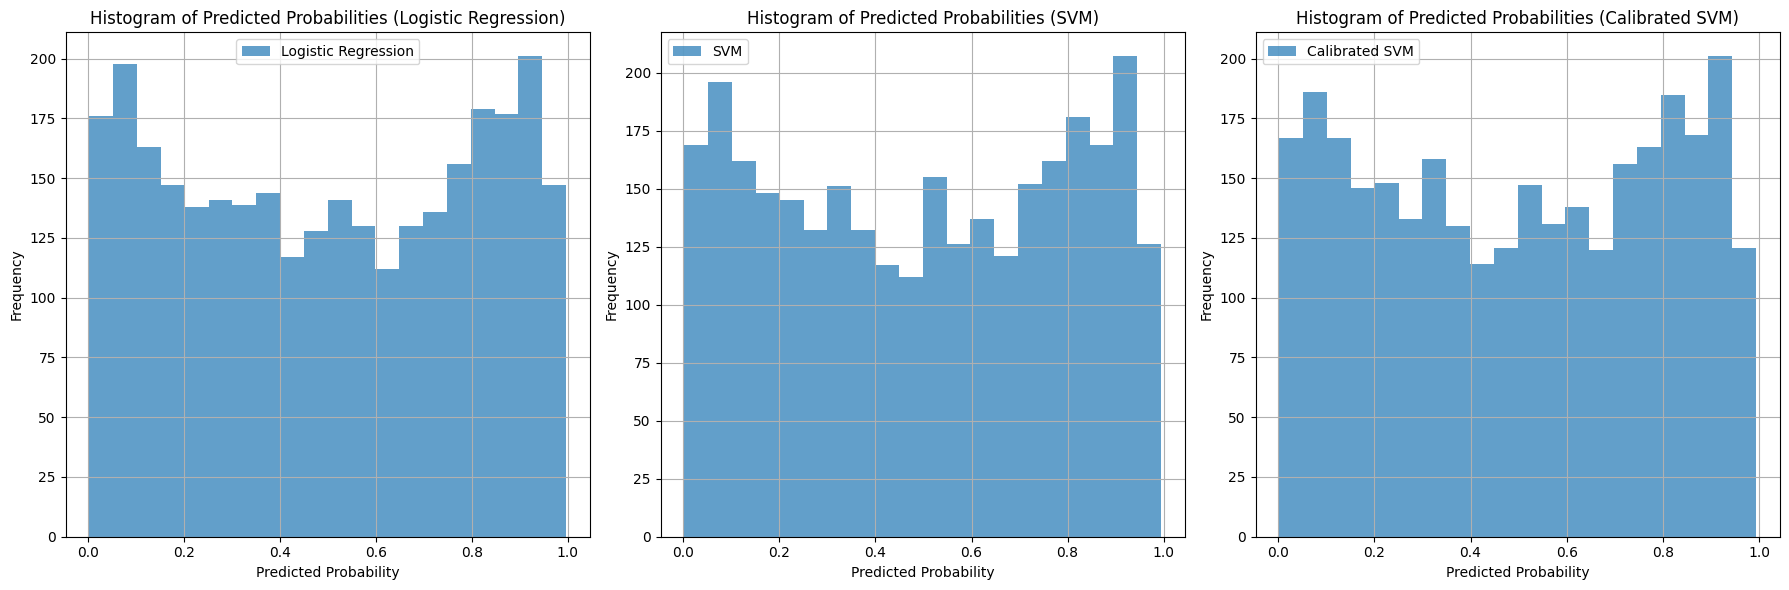

In [52]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plot_histograms(y_pred_log_reg, 'Logistic Regression')
plt.grid(True)

plt.subplot(1, 3, 2)
plot_histograms(y_pred_svm, 'SVM')
plt.grid(True)

plt.subplot(1, 3, 3)
plot_histograms(y_pred_calibrated_svm, 'Calibrated SVM')
plt.grid(True)

plt.tight_layout()
plt.show()

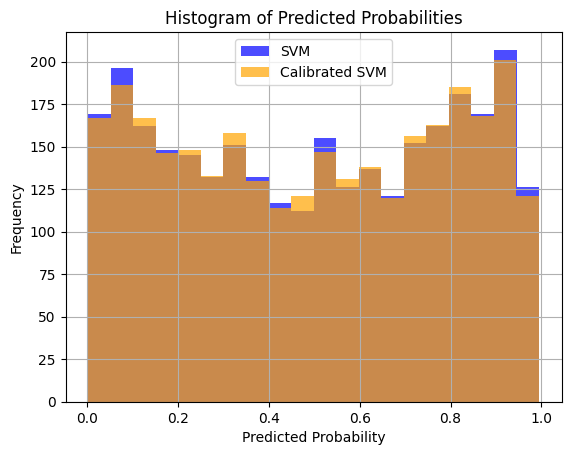

In [63]:
plt.hist(y_pred_svm, bins=20, alpha=0.7, label='SVM', color='blue')
plt.hist(y_pred_calibrated_svm, bins=20, alpha=0.7, label='Calibrated SVM', color='orange')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities')
plt.grid(True)
plt.legend()

In [ ]:
#╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

**Вопрос:** Улучшилась ли калибровочная кривая?

**Ответ:** ╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

### Калибровочные кривые

1. **SVM (оранжевая линия)**:
   - Калибровочная кривая SVM (оранжевая) довольно близка к идеальной диагонали, особенно в среднем и высоком диапазонах вероятностей.

2. **Калиброванный SVM (зелёная линия)**:
   - Калиброванная кривая SVM (зелёная) также близка к диагонали, но не всегда лучше исходной SVM. В некоторых областях, таких как низкие вероятности, она показывает чуть больше отклонений.

### Гистограмма распределения предсказанных вероятностей

1. **SVM (синие полосы)**:
   - Изначальная модель SVM показывает уверенные предсказания с пиками на краях (около 0 и 1).

2. **Калиброванный SVM (оранжевые полосы)**:
   - Калиброванный SVM имеет более сглаженное распределение вероятностей, что может указывать на улучшенную калибровку, но это не всегда означает лучшую производительность.

### Вывод

- **Калибровочная кривая**: Кривая SVM (оранжевая) ближе к идеальной диагонали, чем калиброванная SVM (зелёная), что указывает на то, что исходная SVM уже достаточно хорошо откалибрована.
- **Гистограмма**: Калиброванный SVM показывает более сглаженное распределение предсказанных вероятностей, но это не всегда свидетельствует об улучшенной калибровке.

### Итог

Калибровка с использованием `CalibratedClassifierCV` не всегда приводит к улучшению калибровочной кривой. В данном случае исходная модель SVM демонстрирует калибровочную кривую, более близкую к идеальной, чем калиброванная модель.

##### __Авторское решение__ (0.25 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

1. **Метод Platt (Platt Scaling):**
   - Идея: Метод Platt предполагает применение сигмоидной функции к выходным данным модели для преобразования их в вероятности. Это делается путем обучения дополнительной логистической регрессии на выходах модели.
   - Алгоритм:
     1. Обучите классификатор и получите выходные значения (например, расстояния от гиперплоскости в SVM).
     2. Примените сигмоидную функцию к выходным значениям:
$$
P(y=1|x) = \frac{1}{1 + \exp(Af(x) + B)}
$$ , где A и B - параметры, обучаемые с использованием максимального правдоподобия на обучающем наборе.

2. **Изотоническая регрессия (Isotonic Regression):**
   - Идея: Изотоническая регрессия стремится калибровать вероятности так, чтобы они были монотонно возрастающими относительно выходных значений модели. Это делается путем построения кусочно-линейной функции, которая аппроксимирует истинные вероятности.
   - Алгоритм:
     1. Отсортируйте выходные значения модели и соответствующие истинные метки.
     2. Найдите кусочно-линейную аппроксимацию, которая минимизирует среднеквадратичную ошибку между аппроксимированными вероятностями и истинными метками, сохраняя при этом монотонность.

**Различия:**
- Platt Scaling предполагает использование сигмоидной функции и подходит для моделей, выходы которых могут быть интерпретированы как логиты (например, SVM). Этот метод может не гарантировать монотонность вероятностей.
- Изотоническая регрессия не делает предположений о форме функции, связывающей выходы модели с вероятностями, и стремится к монотонности. Это делает ее более гибкой, но потенциально менее устойчивой при малом количестве данных.


In [58]:
from sklearn.isotonic import IsotonicRegression
from sklearn.base import BaseEstimator, ClassifierMixin


class IsotonicScaling(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator):
        self.base_estimator = base_estimator
        self.iso_model = IsotonicRegression(out_of_bounds='clip')

    def fit(self, X, y):
        # Fit the base estimator
        self.base_estimator.fit(X, y)
        # Get the decision function or predict_proba
        if hasattr(self.base_estimator, "decision_function"):
            scores = self.base_estimator.decision_function(X)
        else:
            scores = self.base_estimator.predict_proba(X)[:, 1]
        # Fit the isotonic regression model on scores
        self.iso_model.fit(scores, y)
        return self

    def predict_proba(self, X):
        # Get the decision function or predict_proba
        if hasattr(self.base_estimator, "decision_function"):
            scores = self.base_estimator.decision_function(X)
        else:
            scores = self.base_estimator.predict_proba(X)[:, 1]
        # Apply isotonic scaling
        probs = self.iso_model.transform(scores)
        return np.vstack([1 - probs, probs]).T


# Обучение метода опорных векторов и калибровка с использованием изотонической регрессии
svm = SVC(kernel='linear', probability=False, random_state=42)
isotonic_scaled_svm = IsotonicScaling(base_estimator=svm)
isotonic_scaled_svm.fit(X_train, y_train)


IsotonicScaling(base_estimator=SVC(kernel='linear', random_state=42))

In [59]:
# Предсказание вероятностей для метода изотонической регрессии
y_pred_isotonic_svm = isotonic_scaled_svm.predict_proba(X_test)[:, 1]


/Users/dmitrii.koriakov/miniconda3/envs/mai-ml-linear-classification-lab5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/dmitrii.koriakov/miniconda3/envs/mai-ml-linear-classification-lab5/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


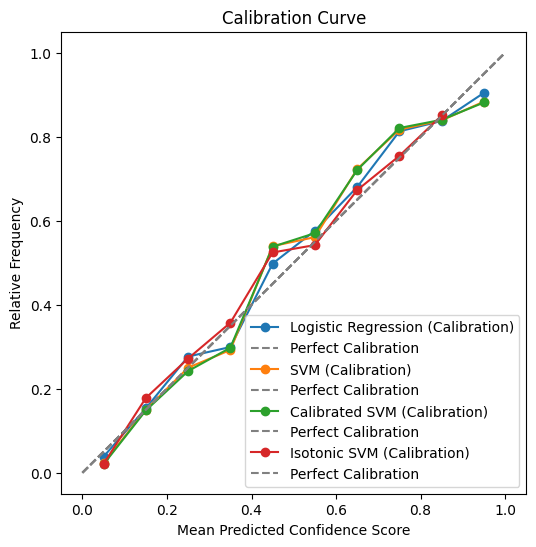

In [60]:
plt.figure(figsize=(6, 6))

plot_calibration_curve(y_test, y_pred_log_reg, 'Logistic Regression')
plot_calibration_curve(y_test, y_pred_svm, 'SVM')
plot_calibration_curve(y_test, y_pred_calibrated_svm, 'Calibrated SVM')
plot_calibration_curve(y_test, y_pred_isotonic_svm, 'Isotonic SVM')

plt.legend()
plt.show()

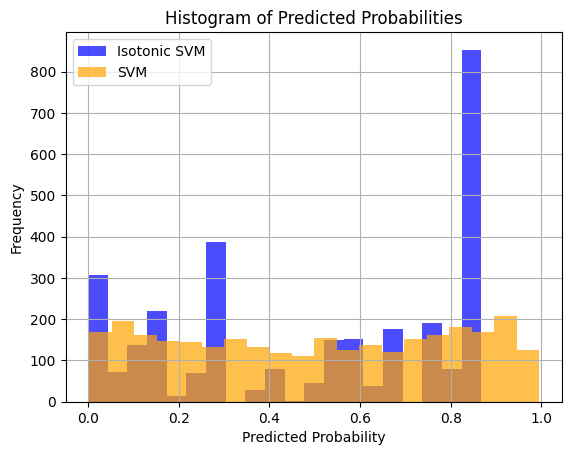

In [64]:
plt.hist(y_pred_isotonic_svm, bins=20, alpha=0.7, label='Isotonic SVM', color='blue')
plt.hist(y_pred_svm, bins=20, alpha=0.7, label='SVM', color='orange')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities')
plt.grid(True)
plt.legend()

In [ ]:
#╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

# Часть 2. Обработка категориальных переменных (1.75 балла)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__


Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [92]:
df = pd.read_csv('bike_buyers.csv')

In [93]:
df

,ID,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
0,12496,Married,Female,40000.0,1.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,Europe,42.0,No
1,24107,Married,Male,30000.0,3.0,Partial College,Clerical,Yes,1.0,0-1 Miles,Europe,43.0,No
2,14177,Married,Male,80000.0,5.0,Partial College,Professional,No,2.0,2-5 Miles,Europe,60.0,No
3,24381,Single,NaN,70000.0,0.0,Bachelors,Professional,Yes,1.0,5-10 Miles,Pacific,41.0,Yes
4,25597,Single,Male,30000.0,0.0,Bachelors,Clerical,No,0.0,0-1 Miles,Europe,36.0,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,23731,Married,Male,60000.0,2.0,High School,Professional,Yes,2.0,2-5 Miles,North America,54.0,Yes
996,28672,Single,Male,70000.0,4.0,Graduate Degree,Professional,Yes,0.0,2-5 Miles,North America,35.0,Yes
997,11809,Married,NaN,60000.0,2.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,North America,38.0,Yes
998,19664,Single,Male,100000.0,3.0,Bachelors,Management,No,3.0,1-2 Miles,North America,38.0,No


In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                1000 non-null   int64  
 1   Marital Status    993 non-null    object 
 2   Gender            989 non-null    object 
 3   Income            994 non-null    float64
 4   Children          992 non-null    float64
 5   Education         1000 non-null   object 
 6   Occupation        1000 non-null   object 
 7   Home Owner        996 non-null    object 
 8   Cars              991 non-null    float64
 9   Commute Distance  1000 non-null   object 
 10  Region            1000 non-null   object 
 11  Age               992 non-null    float64
 12  Purchased Bike    1000 non-null   object 
dtypes: float64(4), int64(1), object(8)
memory usage: 101.7+ KB


In [95]:
df.describe()

,ID,Income,Children,Cars,Age
count,1000.000000,994.000000,992.000000,991.000000,992.000000
mean,19965.992000,56267.605634,1.910282,1.455096,44.181452
std,5347.333948,31067.817462,1.626910,1.121755,11.362007
min,11000.000000,10000.000000,0.000000,0.000000,25.000000
25%,15290.750000,30000.000000,0.000000,1.000000,35.000000
50%,19744.000000,60000.000000,2.000000,1.000000,43.000000
75%,24470.750000,70000.000000,3.000000,2.000000,52.000000
max,29447.000000,170000.000000,5.000000,4.000000,89.000000


In [96]:

# Разделим целевой признак и признаки
X = df.drop(columns=['Purchased Bike'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')


In [97]:
for col in X.columns:
    display(X[col].value_counts())

ID
12496    1
22252    1
19133    1
24643    1
21599    1
        ..
15926    1
14554    1
16468    1
19174    1
12121    1
Name: count, Length: 1000, dtype: int64

Marital Status
Married    535
Single     458
Name: count, dtype: int64

Gender
Male      500
Female    489
Name: count, dtype: int64

Income
60000.0     165
40000.0     153
30000.0     134
70000.0     123
80000.0      90
20000.0      74
10000.0      73
50000.0      40
90000.0      38
130000.0     32
100000.0     29
120000.0     17
110000.0     16
150000.0      4
160000.0      3
170000.0      3
Name: count, dtype: int64

Children
0.0    274
2.0    209
1.0    169
3.0    133
4.0    126
5.0     81
Name: count, dtype: int64

Education
Bachelors              306
Partial College        265
High School            179
Graduate Degree        174
Partial High School     76
Name: count, dtype: int64

Occupation
Professional      276
Skilled Manual    255
Clerical          177
Management        173
Manual            119
Name: count, dtype: int64

Home Owner
Yes    682
No     314
Name: count, dtype: int64

Cars
2.0    342
1.0    267
0.0    238
3.0     85
4.0     59
Name: count, dtype: int64

Commute Distance
0-1 Miles     366
5-10 Miles    192
1-2 Miles     169
2-5 Miles     162
10+ Miles     111
Name: count, dtype: int64

Region
North America    508
Europe           300
Pacific          192
Name: count, dtype: int64

Age
40.0    40
47.0    39
38.0    37
36.0    37
43.0    36
35.0    35
42.0    34
32.0    33
37.0    32
45.0    31
34.0    31
48.0    29
41.0    28
46.0    27
44.0    27
30.0    26
52.0    25
31.0    25
53.0    24
50.0    23
27.0    23
49.0    23
51.0    22
39.0    22
28.0    22
33.0    21
59.0    20
55.0    17
26.0    16
29.0    16
56.0    16
54.0    16
60.0    14
66.0    14
62.0    13
58.0    12
67.0    10
64.0    10
63.0     9
65.0     9
61.0     9
57.0     8
69.0     8
25.0     5
73.0     4
70.0     4
68.0     3
78.0     2
80.0     1
89.0     1
74.0     1
71.0     1
72.0     1
Name: count, dtype: int64

In [98]:
categorical_columns = ["Region", "Marital Status", "Commute Distance", "Gender", "Cars", "Home Owner", "Occupation",
                       "Education", "Children", ]
numerical_columns = ["Age", "Income"]

In [112]:
# Разделим на категориальные признаки и числовые
X_numerical = X[numerical_columns].astype(float)
X_categorical = X[categorical_columns].astype(str)
X_categorical = X_categorical.fillna('undefined')
X_numerical.dtypes

Age       float64
Income    float64
dtype: object

In [113]:
X_categorical.dtypes

Region              object
Marital Status      object
Commute Distance    object
Gender              object
Cars                object
Home Owner          object
Occupation          object
Education           object
Children            object
dtype: object

In [114]:
set(df.columns) - (set(X_numerical.columns) | set(X_categorical.columns))

{'ID', 'Purchased Bike'}

В начале поработаем только с категориальными признаками

In [115]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.3, random_state=42, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.25 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [121]:
from sklearn.preprocessing import OrdinalEncoder
import time

ordinal_encoder = OrdinalEncoder()
column_transformer = ColumnTransformer(transformers=[
    ('cat', ordinal_encoder, categorical_columns)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('ordianl', column_transformer),
    ('logreg', LogisticRegression(random_state=42, max_iter=10000))
])

start_time = time.time()
pipeline.fit(X_train, y_train)
training_time = time.time() - start_time

y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
auc_pr = auc(recall, precision)

print(f"AUC-PR: {auc_pr:.5f}")
print(f"Training time: {training_time:.5f} seconds")

AUC-PR: 0.60954
Training time: 0.00502 seconds


In [ ]:
#╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

#### __Задание 4. One-Hot Encoding__ (0.25 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [122]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve, auc

one_hot_encoder = OneHotEncoder(drop='first')
column_transformer = ColumnTransformer(transformers=[
    ('cat', one_hot_encoder, categorical_columns)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('onehot', column_transformer),
    ('logreg', LogisticRegression(random_state=42, max_iter=10000))
])

start_time = time.time()
pipeline.fit(X_train, y_train)
training_time = time.time() - start_time

y_pred_proba_onehot = pipeline.predict_proba(X_test)[:, 1]

precision_onehot, recall_onehot, _ = precision_recall_curve(y_test, y_pred_proba_onehot)
auc_pr_onehot = auc(recall_onehot, precision_onehot)

print(f"AUC-PR (one-hot): {auc_pr_onehot:.5f}")
print(f"Training time (one-hot): {training_time:.5f} seconds")

AUC-PR (one-hot): 0.66067
Training time (one-hot): 0.00551 seconds


In [ ]:
#╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


Я заметил милисекунды на М3

#### __Задание 5. Mean-target Encoding__ (0.5 балла)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Напомню идею формулы:
   - `g_j(x, X)` - новое значение признака `f_j(x)` после кодирования счётчиками.
   - `f_j(x)` - значение j-го категориального признака для объекта `x`.
   - `f_j(x_i)` - значение j-го категориального признака для i-го объекта в обучающем наборе данных `X`.
   - `y_i` - значение целевой переменной для i-го объекта.
   - `[...]` - скобки обозначают индикаторную функцию, которая равна 1, если условие внутри них истинно, и 0 в противном случае.
   - В числителе суммируются значения целевой переменной для объектов, у которых признак `f_j` равен значению признака `f_j(x)` для текущего объекта `x`, и эти значения целевой переменной равны +1.
   - В знаменателе подсчитывается общее количество объектов, у которых признак `f_j` равен значению признака `f_j(x)` для текущего объекта `x`.

**Результат:** Каждое уникальное значение категориального признака заменяется средним значением целевой переменной по всем объектам этой категории. Это позволяет сохранить информацию о связи между категориальным признаком и целевой переменной без увеличения размерности признакового пространства, как это происходит при one-hot encoding.\
\
\
\
Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.\

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [126]:
from copy import deepcopy


def mean_target_encoding(X_train, X_test, y_train, categorical_columns):
    X_train_encoded = deepcopy(X_train)
    X_test_encoded = deepcopy(X_test)

    for col in categorical_columns:
        means = y_train.groupby(X_train[col]).mean()

        X_train_encoded[col] = X_train[col].map(means)
        X_test_encoded[col] = X_test[col].map(means)

    return X_train_encoded, X_test_encoded


log_reg = LogisticRegression(random_state=42, max_iter=10000)

start_time = time.time()

X_train_encoded, X_test_encoded = mean_target_encoding(X_train, X_test, y_train, categorical_columns)

log_reg.fit(X_train_encoded, y_train)
training_time = time.time() - start_time

y_pred_proba_mean_target = log_reg.predict_proba(X_test_encoded)[:, 1]

precision_mean_target, recall_mean_target, _ = precision_recall_curve(y_test, y_pred_proba_mean_target)
auc_pr_mean_target = auc(recall_mean_target, precision_mean_target)

print(f"AUC-PR (mean-target): {auc_pr_mean_target:.5f}")
print(f"Training time (mean-target): {training_time:.5f} seconds")

AUC-PR (mean-target): 0.65435
Training time (mean-target): 0.00748 seconds


In [ ]:
#╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

**Mean-target encoding** может привести к переобучению (если у нас есть маленькие категории, то мы просто запомним для них целевую переменную). Чтобы избежать переобучения необходимо вычислять счётчики таким образом, чтобы целевая метка конкретного объекта не влияла напрямую на его собственное значение признака. Для этого можно использовать следующие методы:

1. **Вычисление по предшествующим объектам:** Если данные отсортированы по времени или другому критерию, можно вычислять значение счётчика для каждого объекта, используя только те объекты, которые находятся выше в датасете. Таким образом, целевая метка текущего объекта не участвует в вычислении его признака. (собственно так реализовано в знаменитой библиотеке от Yandex Catboost)

2. **Вычисление по фолдам:** Можно разделить выборку на несколько частей (фолдов) и для каждой части вычислить значение признака, используя данные из всех остальных фолдов. Этот подход аналогичен методу кросс-валидации и позволяет избежать использования целевой метки объекта при вычислении его признака.

3. **Добавление шума:** Внесение небольшого случайного шума в посчитанные значения признаков может также помочь снизить риск переобучения, делая признаки менее "идеальными" и более устойчивыми к изменениям в данных.


#### __Задание 6. Пошумим, блин!__  (0.25 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [128]:
def mean_target_encoding_with_noise(X_train, X_test, y_train, categorical_columns, noise_level=0.01):
    X_train_encoded = X_train.copy()
    X_test_encoded = X_test.copy()

    for col in categorical_columns:
        means = y_train.groupby(X_train[col]).mean()

        X_train_encoded[col] = X_train[col].map(means) + noise_level * np.random.randn(len(X_train))
        X_test_encoded[col] = X_test[col].map(means) + noise_level * np.random.randn(len(X_test))

    return X_train_encoded, X_test_encoded


X_train_encoded_noise, X_test_encoded_noise = mean_target_encoding_with_noise(X_train, X_test, y_train,
                                                                              categorical_columns)

start_time = time.time()
log_reg = LogisticRegression(random_state=42, max_iter=10000)
log_reg.fit(X_train_encoded_noise, y_train)
training_time_noise = time.time() - start_time

y_pred_proba_noise = log_reg.predict_proba(X_test_encoded_noise)[:, 1]

precision_noise, recall_noise, _ = precision_recall_curve(y_test, y_pred_proba_noise)
auc_pr_noise = auc(recall_noise, precision_noise)

print(f"AUC-PR (mean-target with noise): {auc_pr_noise:.5f}")
print(f"Training time (mean-target with noise): {training_time_noise:.5f} seconds")

AUC-PR (mean-target with noise): 0.65031
Training time (mean-target with noise): 0.00224 seconds


In [127]:
#╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** ╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

Добавление шума при mean-target encoding немного снизило метрику AUC-PR, но также уменьшило риск переобучения и сделало модель более устойчивой. Разница в AUC-PR незначительна, что указывает на то, что модель все еще сохраняет высокую точность, несмотря на введение шума.

#### __Задание 7. Сглаживание счетчиков__  (0.5 балла)

Давайте рассмотрим ситуацию, когда определенная категория встречается в датасете всего несколько раз. В таком случае, среднее значение целевой переменной для этой категории может быть нестабильным и привести к переобучению. Чтобы уменьшить этот риск, используется сглаживание счётчиков.

Один из способов сглаживания - это использование среднего значения по всей выборке. В этом случае формула для вычисления значения счётчика модифицируется следующим образом:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$

Здесь:
- $global\_mean$ — это доля объектов положительного класса во всей выборке.
- $C$ — параметр сглаживания, который контролирует баланс между средним значением по категории и глобальным средним. Большие значения $C$ увеличивают влияние глобального среднего, что полезно для редких категорий.

Смысл сглаживания в том, что мы "разбавляем" среднее значение по категории глобальным средним. Это помогает сделать признак более устойчивым, особенно для категорий с малым количеством объектов.

**Пример:** Представим, что у нас есть категория "цвет автомобиля", и в выборке всего два красных автомобиля, один из которых положительный (например, продан), а другой отрицательный (не продан). Без сглаживания счётчик для красных автомобилей будет равен 0.5. Однако, если использовать сглаживание с $C = 10$ и $global\_mean = 0.3$ (30% автомобилей в выборке проданы), то счётчик для красных автомобилей будет равен:

$$
g_j(\text{"красный"}, X) = \frac{1 + 10 \times 0.3}{2 + 10} = \frac{4}{12} = 0.33
$$

Таким образом, значение счётчика становится ближе к глобальному среднему, что делает его менее чувствительным к случайностям в данных.

Повторите эксперименты с добавлением сглаживания и подберите параметр $C$ так, чтобы качество модели было лучше, чем при использовании One-Hot-Encoding.

In [130]:
def mean_target_encoding_with_smoothing(X_train, X_test, y_train, categorical_columns, C):
    X_train_encoded = X_train.copy()
    X_test_encoded = X_test.copy()
    global_mean = y_train.mean()
    
    for col in categorical_columns:
        means = y_train.groupby(X_train[col]).mean()
        counts = X_train[col].value_counts()
        
        smoothed_means = (means * counts + global_mean * C) / (counts + C)
        
        X_train_encoded[col] = X_train[col].map(smoothed_means)
        X_test_encoded[col] = X_test[col].map(smoothed_means)
    
    return X_train_encoded, X_test_encoded

best_auc_pr = 0
best_C = None
for C in [1, 5, 10, 20, 50, 100]:
    X_train_encoded_smooth, X_test_encoded_smooth = mean_target_encoding_with_smoothing(X_train, X_test, y_train, categorical_columns, C)
    
    log_reg = LogisticRegression(random_state=42, max_iter=10000)
    log_reg.fit(X_train_encoded_smooth, y_train)
    
    y_pred_proba_smooth = log_reg.predict_proba(X_test_encoded_smooth)[:, 1]
    
    precision_smooth, recall_smooth, _ = precision_recall_curve(y_test, y_pred_proba_smooth)
    auc_pr_smooth = auc(recall_smooth, precision_smooth)
    
    print(f"auc_pr_smooth[{auc_pr_smooth}] > best_auc_pr[{best_auc_pr}]: {auc_pr_smooth > best_auc_pr}")
    if auc_pr_smooth > best_auc_pr:
        best_auc_pr = auc_pr_smooth
        best_C = C

print(f"Best AUC-PR (mean-target with smoothing): {best_auc_pr:.5f} with C={best_C}")

X_train_encoded_smooth, X_test_encoded_smooth = mean_target_encoding_with_smoothing(X_train, X_test, y_train, categorical_columns, best_C)

start_time = time.time()
log_reg = LogisticRegression(random_state=42, max_iter=10000)
log_reg.fit(X_train_encoded_smooth, y_train)
training_time_smooth = time.time() - start_time


y_pred_proba_smooth = log_reg.predict_proba(X_test_encoded_smooth)[:, 1]

precision_smooth, recall_smooth, _ = precision_recall_curve(y_test, y_pred_proba_smooth)
auc_pr_smooth = auc(recall_smooth, precision_smooth)

print(f"AUC-PR (mean-target with smoothing): {auc_pr_smooth:.5f}")
print(f"Training time (mean-target with smoothing): {training_time_smooth:.5f} seconds")

auc_pr_smooth[0.6539137105264139] > best_auc_pr[0]: True
auc_pr_smooth[0.6536805648726193] > best_auc_pr[0.6539137105264139]: False
auc_pr_smooth[0.6520174322222214] > best_auc_pr[0.6539137105264139]: False
auc_pr_smooth[0.6526278319157366] > best_auc_pr[0.6539137105264139]: False
auc_pr_smooth[0.647243278501042] > best_auc_pr[0.6539137105264139]: False
auc_pr_smooth[0.6433898554952937] > best_auc_pr[0.6539137105264139]: False
Best AUC-PR (mean-target with smoothing): 0.65391 with C=1
AUC-PR (mean-target with smoothing): 0.65391
Training time (mean-target with smoothing): 0.00220 seconds


Добавление сглаживания в mean-target encoding помогло уменьшить риск переобучения для категорий с малым количеством объектов, сохранив при этом высокую метрику AUC-PR. Сглаживание делает признаки более устойчивыми и менее чувствительными к случайным вариациям в данных. Таким образом, использование mean-target encoding со сглаживанием является эффективным способом кодирования категориальных признаков, обеспечивая баланс между качеством модели и устойчивостью к переобучению.

In [ ]:
#╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

# Часть 3. Отбор признаков (1 балл)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [131]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2024-05-27 00:48:46--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.data’

adult.data              [     <=>            ]   3.79M  2.96MB/s    in 1.3s    

2024-05-27 00:48:49 (2.96 MB/s) - ‘adult.data’ saved [3974305]



In [134]:
columns = ['age', 'workclass', 'fnlwgt', 'education',
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
5945,20,Private,116375,9th,5,Never-married,Sales,Own-child,White,Female,0,0,40,United-States,0


In [135]:
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,0


In [139]:
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income             int32
dtype: object

Отбор признаков - важный этап в построении модели. Некоторые признаки могут не вносить значимый вклад в модель или даже ухудшать её качество, при этом их вычисление требует времени. Давайте попробуем разные способы отбора признаков и оценим их влияние на качество модели и время, затраченное на их обработку.

Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`.

In [140]:
X = df.drop(columns=['income'])
y = df['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

categorical_columns = X.select_dtypes(include=['object']).columns
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns


In [141]:
X.select_dtypes(include=['object']).columns

Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object')

In [142]:
numerical_columns

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')

In [138]:
#╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [143]:
one_hot_encoder = OneHotEncoder(drop='first')
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', one_hot_encoder, categorical_columns)
    ],
    remainder='passthrough'
)

X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

num_new_features = X_train_encoded.shape[1]
num_new_features

100

In [ ]:
#╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [144]:
log_reg = LogisticRegression(random_state=42, max_iter=10000)
log_reg.fit(X_train_encoded, y_train)

y_pred_proba = log_reg.predict_proba(X_test_encoded)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
auc_pr = auc(recall, precision)

print(f"AUC-PR: {auc_pr:.5f}")

AUC-PR: 0.75528


/Users/dmitrii.koriakov/miniconda3/envs/mai-ml-linear-classification-lab5/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### __Задание 8. Встроенные методы (0.25 балла)__

Давайте выберем 40 самых важных признаков с помощью линейной модели. В линейной модели веса показывают, насколько сильно каждый признак влияет на прогноз. Мы можем использовать модуль этих весов, чтобы оценить важность признаков. Этот подход называется встроенным методом отбора признаков.

Выберем 40 признаков с самыми большими весами, обучим модель снова и проверим её качество. Также замерим, сколько времени занимает этот процесс отбора признаков.

In [145]:
feature_importances = np.abs(log_reg.coef_[0])
training_time_full = time.time() - start_time

top_40_indices = np.argsort(feature_importances)[-40:]

In [146]:
X_train_top_40 = X_train_encoded[:, top_40_indices]
X_test_top_40 = X_test_encoded[:, top_40_indices]

start_time = time.time()
log_reg_top_40 = LogisticRegression(random_state=42, max_iter=10000)
log_reg_top_40.fit(X_train_top_40, y_train)
training_time_top_40 = time.time() - start_time

y_pred_proba_top_40 = log_reg_top_40.predict_proba(X_test_top_40)[:, 1]

precision_top_40, recall_top_40, _ = precision_recall_curve(y_test, y_pred_proba_top_40)
auc_pr_top_40 = auc(recall_top_40, precision_top_40)

print(f"AUC-PR with top 40 features: {auc_pr_top_40:.5f}")
print(f"Training time with top 40 features: {training_time_top_40:.5f} seconds")

AUC-PR with top 40 features: 0.67013
Training time with top 40 features: 0.02735 seconds


In [ ]:
#╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

Изменилось ли качество? Как?

Мы предполагали, что все признаки вносят равный вклад, не учитывая их масштаб. Но масштаб важен: если увеличить признак в 100 раз, его вес в модели уменьшится на 100. Поэтому, прежде чем выбирать признаки, нужно их отмасштабировать.

Сначала масштабируем признаки, а затем удалим ненужные. Пересчитаем качество модели на всех признаках. Если вы уже масштабировали признаки в начале, попробуйте теперь отобрать признаки на данных без масштабирования.

Какой результат получился?

Значительное снижение метрики, что может свидетельствовать о том, что выбранные признаки не в полной мере отражают всю важную информацию, которая была доступна в исходных данных.

Возможно, что отбор только 40 признаков не охватывает всю необходимую информацию для точного предсказания целевой переменной.

#### __Задание 9. Методы фильтрации (0.25 балла)__


Давайте выберем признаки более осмысленно, используя методы фильтрации. Эти методы выбирают признаки на основе некоторой статистической функции. Мы будем использовать t-статистику для каждого признака:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ - среднее, стандартное отклонение и количество объектов для каждого класса.

*Интуиция формулы:*

Идея t-статистики заключается в том, чтобы оценить, насколько сильно средние значения признака отличаются между двумя классами, с учетом разброса (дисперсии) значений признака внутри каждого класса.

- Числитель $|\mu_+ - \mu_-|$ показывает абсолютную разницу между средними значениями признака в положительном и отрицательном классах. Чем больше эта разница, тем более вероятно, что признак важен для разделения классов.

- Знаменатель $\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}$ учитывает стандартные отклонения признака в каждом классе и количество объектов в классах. Это помогает учесть, насколько сильно значения признака разбросаны внутри классов. Если разброс большой, то разница средних может быть менее значимой.

В итоге, если значение t-статистики велико, это говорит о том, что признак имеет высокую дискриминационную способность между классами, то есть хорошо помогает их различать. Поэтому мы отбираем признаки с наибольшими значениями t-статистики, полагая, что они наиболее важны для модели.

Выберем 40 признаков с самым высоким значением t-статистики, обучим модель заново и оценим её качество. Также замерим время, затраченное на отбор признаков.


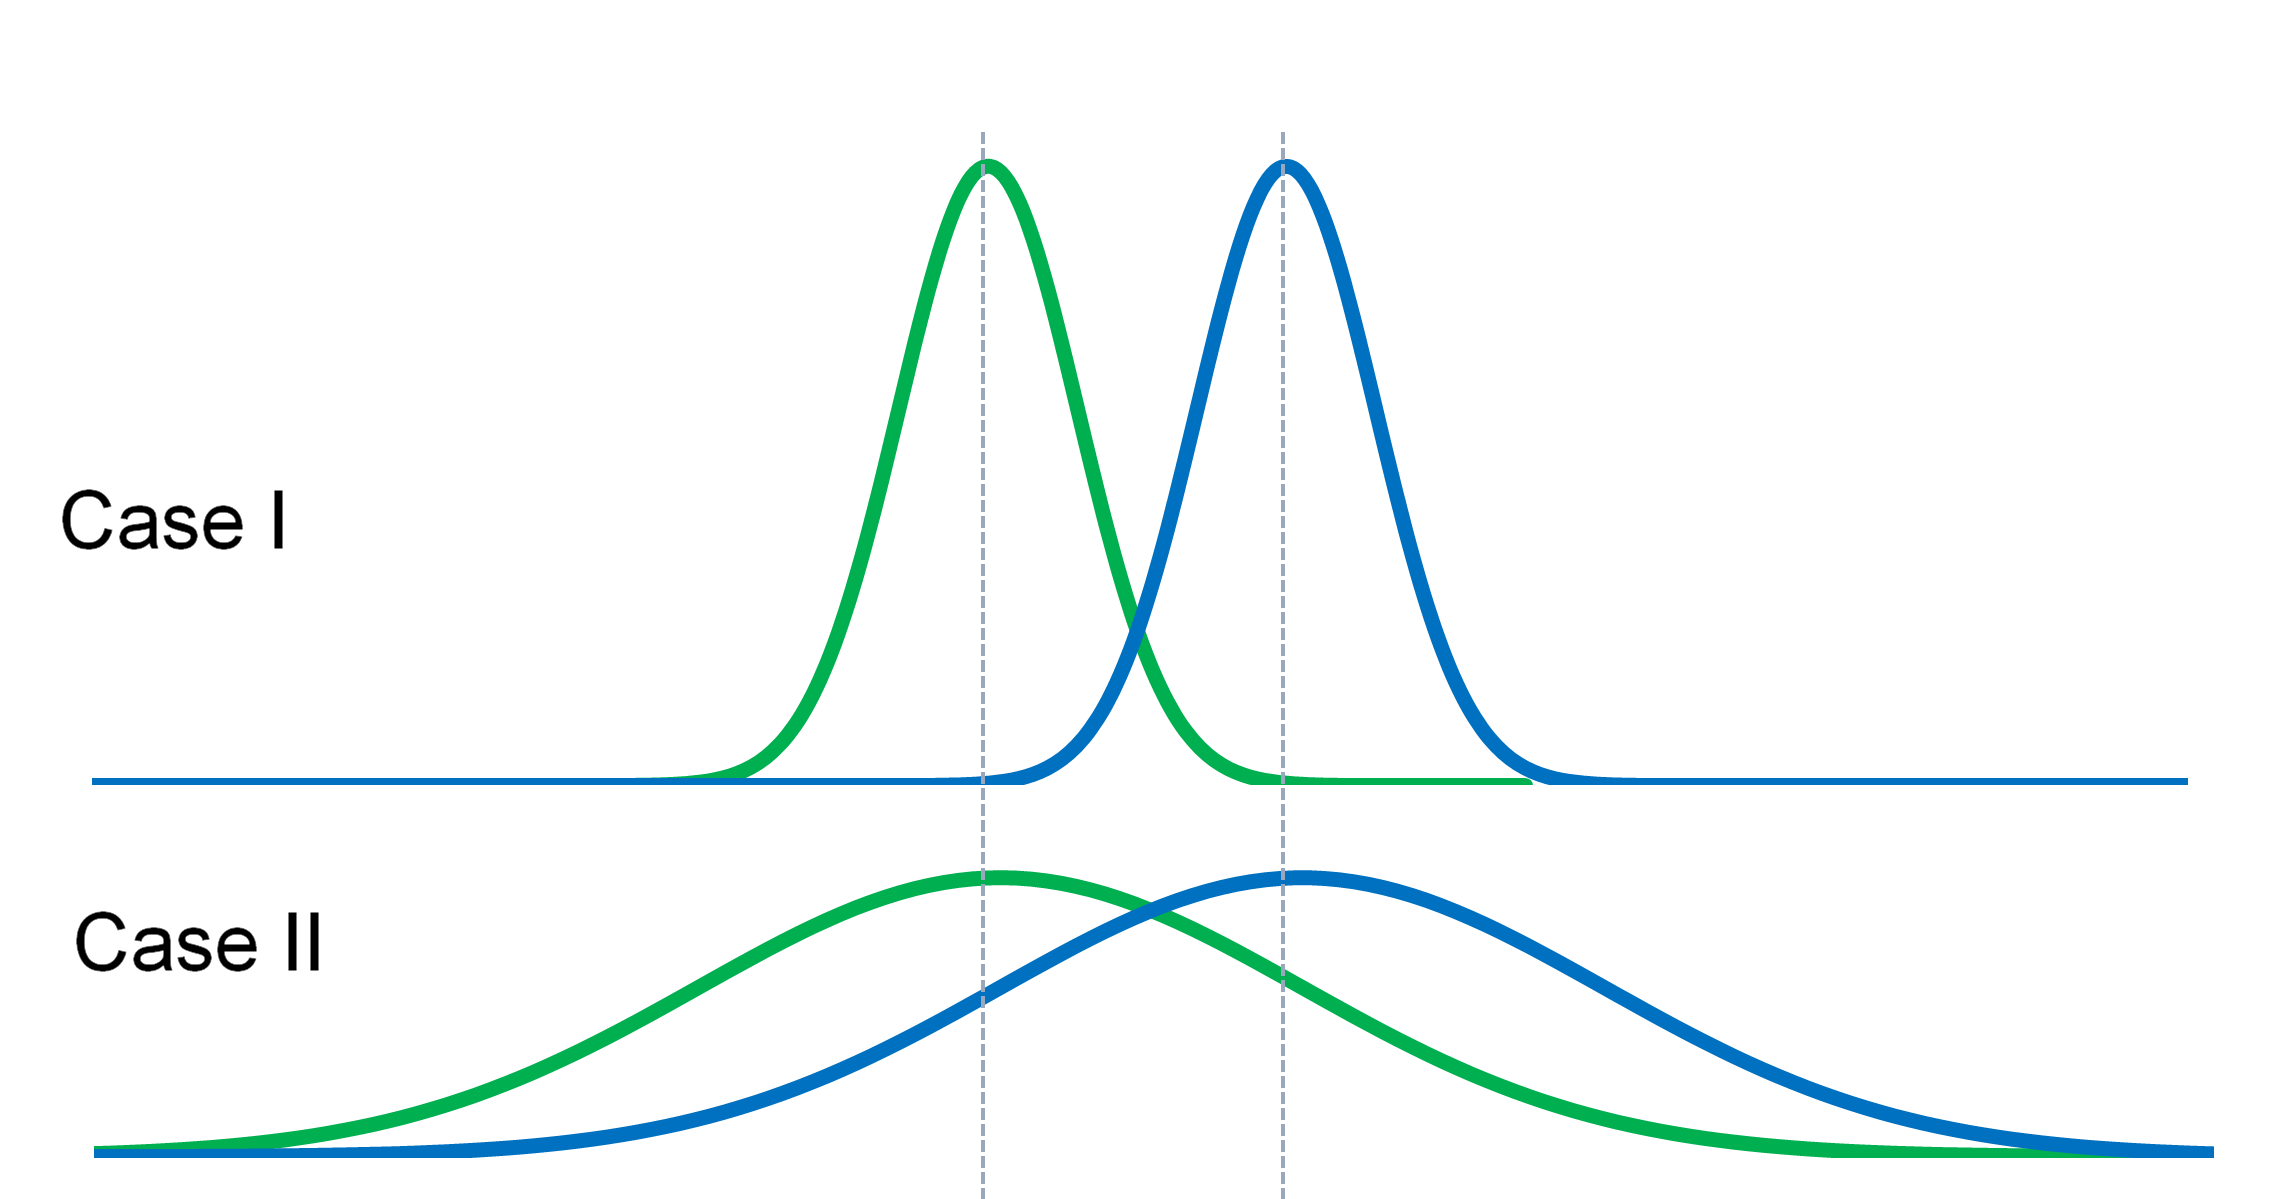

In [ ]:
#╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

#### __Задание 10. Методы-обёртки__ (0.5 балла)

Третий из рассматриваемых нами методов работает следующим образом: мы используем жадный метод удаления признаков: на каждом шаге убираем тот признак, который меньше всего влияет на качество модели. Продолжаем так, пока не останется 40 признаков или пока качество не начнет сильно падать.

Важно: оцениваем качество не на тестовой выборке, чтобы избежать переобучения. Для этого делим обучающую выборку на две части: на одной обучаем модель без одного признака, на другой - проверяем качество. Тестовую выборку используем только для финальной проверки.

**Пример:** Предположим, у нас есть модель с признаками A, B, C, D. Сначала убираем признак A, обучаем модель на B, C, D и проверяем качество. Затем возвращаем A, убираем B и так далее. Если оказалось, что без признака C качество выше всего, убираем C навсегда. Продолжаем, пока не останется 40 признаков.

После отбора 40 признаков оцениваем качество на тестовой выборке и замеряем время, затраченное на отбор.


In [ ]:
#╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [ ]:
#╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** ╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

# Часть 4. Оценка экономического эффекта (1 балл)



В этой части мы сосредоточимся на задачах, которые часто встречаются на практике (помимо рекурсивного обхода`json` и перекладывания`.yml`файлов, разумеется):

- Создадим несколько специализированных метрик качества.
- Настроим модель так, чтобы максимизировать прибыль.
- Оценим потенциальный доход от использования модели.

Для простоты введем некоторые упрощения. Напомним, что выручка - это сумма денег, полученная от клиентов, а прибыль - это выручка за вычетом расходов, таких как зарплата и другие затраты.


#### __Задание 11. Прогноз по доходам и расходам__ (0.5 балла)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

In [ ]:
df.head()

In [ ]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=555`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [ ]:
#╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [ ]:
#╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [ ]:
#╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [ ]:
#╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

In [ ]:
#╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [ ]:
#╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

#### __Задание 12. Ключевая метрика__ (0.5 балла)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ #╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [ ]:
#╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог.




In [ ]:
#╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [ ]:
#╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ